<h1> Automated Chord Analysis With Music21</h1>

My friend Mayank Sanganeria and I recently deployed a webapp called [ChordNamer](www.chordnamer.link), which takes in an arbitraty MusicXML file, and returns a new one with chord symbols for each bar.

Let's dive into how the script works using examples from the OSTs for *Legend of Zelda: Ocarina of Time*, and *I Am Setsuna*. For each of these examples, I downloaded transcriptions from the MuseScore online community.

<h2>Automated Chord Analysis</h2>

Using the `chordify()` function, we can have music21 reduce the score to a single staff that combines all of the voices into a set of chords. Once we have those chords, we also have tools for automatically generating chord symbols and Roman Numeral analysis symbols. In the below script, I also force close positition in octave 4 for G clef readability.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


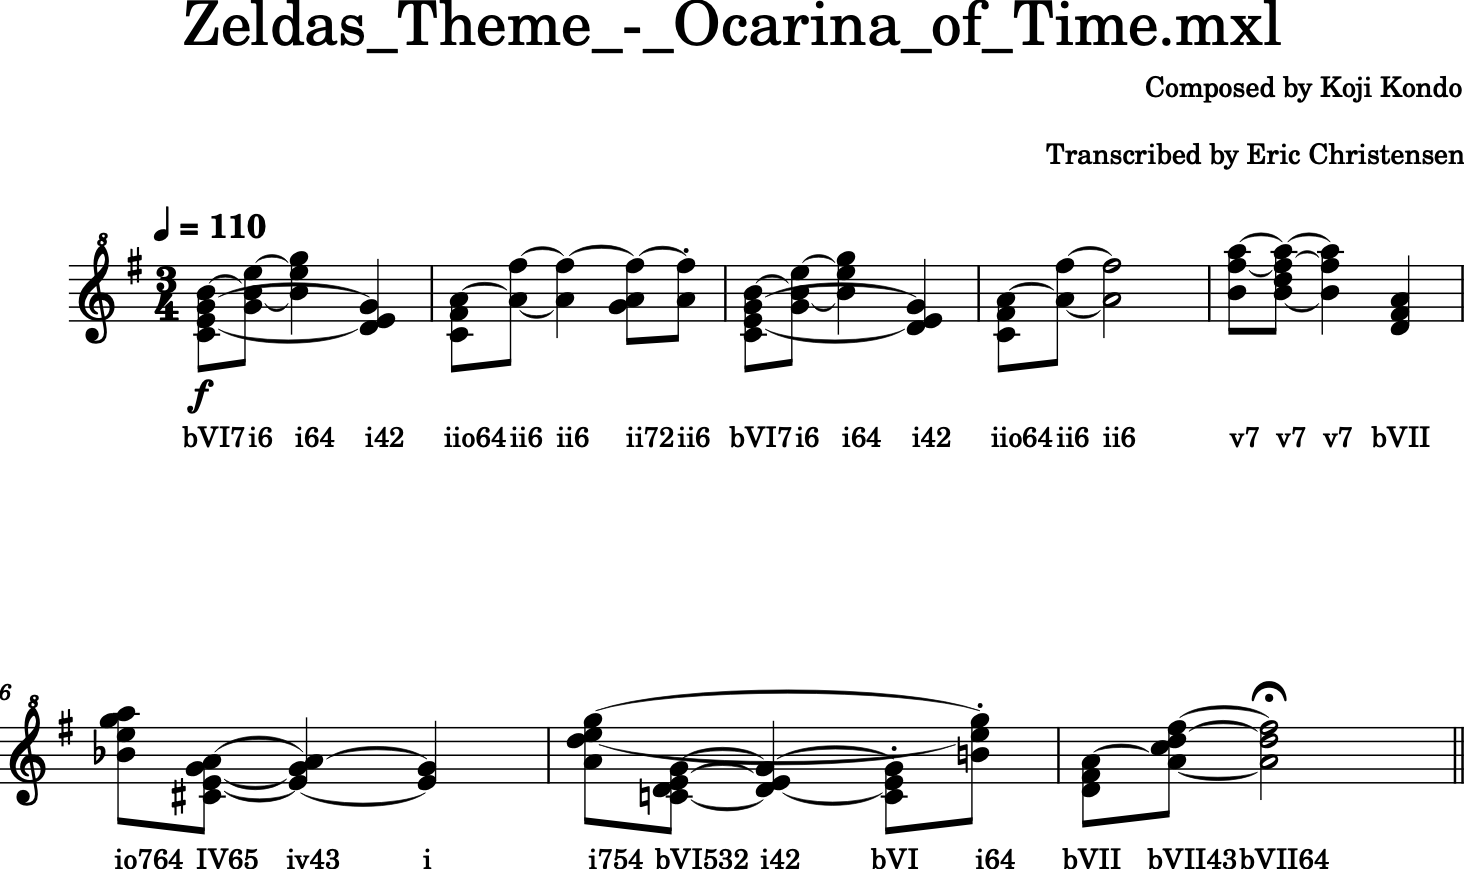

In [1]:
import music21 as m21

# Load the orchestral score
score = m21.converter.parse('./OOT_MXML/Zeldas_Theme_-_Ocarina_of_Time.mxl')

# Chordify the full score to combine all parts into chords
chords = score.chordify()

# Function to convert chords to close position and force to octave 4
def close_position_and_octave_4(chord):
    """Converts a chord to close position and forces all notes to octave 4."""
    chord.closedPosition(forceOctave=4, inPlace=True)
    return chord

# Apply the transformation to each chord
for element in chords.flat.notesAndRests:
    if isinstance(element, m21.chord.Chord):
        close_position_and_octave_4(element)

# Analyze the key of the full score
key = score.analyze('key')

# Perform Roman numeral analysis and add as lyrics to the score
for element in chords.flat.notesAndRests:
    if isinstance(element, m21.note.Note):
        rn = m21.roman.romanNumeralFromChord(m21.chord.Chord([element]), key)
        element.addLyric(rn.figure)
    elif isinstance(element, m21.chord.Chord):
        rn = m21.roman.romanNumeralFromChord(element, key)
        element.addLyric(rn.figure)


# Show the modified score with Roman numerals and close position chords in octave 4
select = chords.measures(1,8)
select.show()

As we can see, while this type of analysis may work well for classical music, it's not as well suited to more contemporary genres, which are more based on the "lead sheet" format from jazz (i.e. each measure has a melody and a couple chords).

Toward that, we could make a couple of simplifying assumptions for now.

- One chord per bar
- The first instrument listed in the score is the melody, which we can exclude from harmonic analysis if we want. Here, the ocarina has the melody and is listed first on the score, so this assumption is correct.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


C major


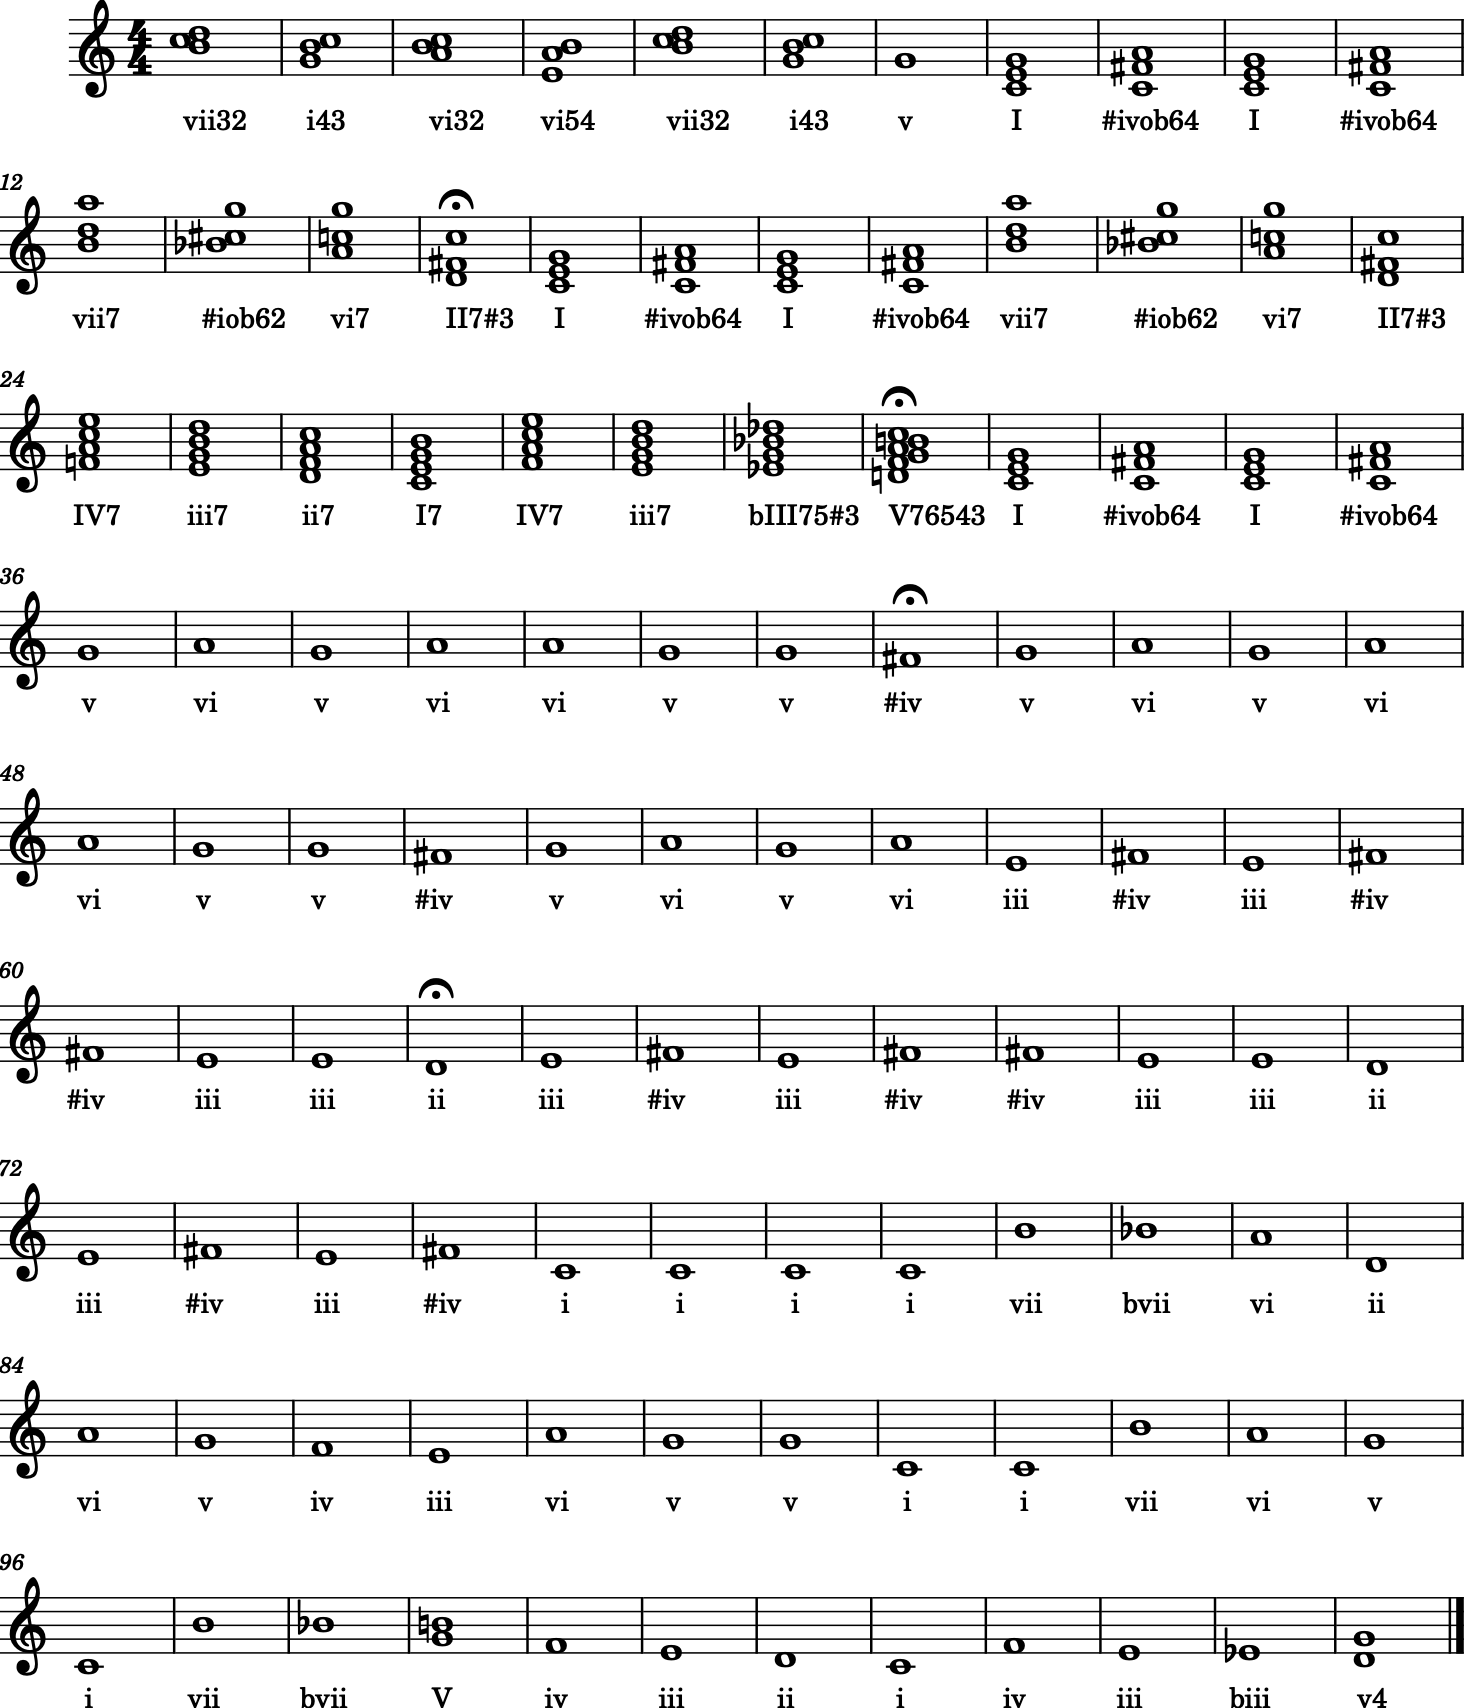

In [2]:
# Load the orchestral score
score = m21.converter.parse('./OOT_MXML/Zeldas_Theme_-_Ocarina_of_Time.mxl')

# Assume the melody is the highest part (commonly the first part)
melody_part = score.parts[0]

# Create a new score without the melody part
harmonic_score = m21.stream.Score()

# Iterate over each part except the melody part
for part in score.parts[1:]:
    filtered_part = m21.stream.Part()
    
    # Iterate through each measure in the part
    for measure in part.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all notes and chords in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)
        
        if notes_in_measure:
            # Create a chord from all notes in the measure
            combined_chord = m21.chord.Chord(notes_in_measure)
            combined_chord.duration = m21.duration.Duration(4.0)  # Assume the chord lasts a whole measure
            
            # Add the chord to the filtered part
            filtered_part.append(combined_chord)
    
    harmonic_score.append(filtered_part)

# Chordify the resulting harmonic score to combine all parts into chords per measure
chords = harmonic_score.chordify()

# Function to convert chords to close position and force them to octave 4
def close_position_and_octave_4(chord):
    """Converts a chord to close position and forces all notes to octave 4."""
    chord.closedPosition(forceOctave=4, inPlace=True)
    return chord

# Apply the transformation to each chord
for element in chords.flat.notesAndRests:
    if isinstance(element, m21.chord.Chord):
        close_position_and_octave_4(element)

# Analyze the key of the harmonic score
key = harmonic_score.analyze('key')
# Prefer major over minor by converting minor to its relative major
if key.mode == 'minor':
    key = key.relative
print(key)

# Perform Roman numeral analysis and add as lyrics to the chords
for element in chords.flat.notesAndRests:
    if isinstance(element, m21.chord.Chord):
        rn = m21.roman.romanNumeralFromChord(element, key)
        element.addLyric(rn.figure)


# Show the modified score with Roman numerals and close position chords in octave 4
chords.show()

This is starting to look more like the Roman Numeral analyses we're used to seeing in popular genres based on jazz.

Let's switch over, however, to looking at chord symbols, which are easier to troubleshoot. It also doesn't bake in any assumptions about the mode that is being used in the song (i.e. for a key signature with no sharps or flats, whether it's best analyzed as being in C major, A minor, or D Dorian).

While we're at it, let's also try including the melody, because if it's hitting extensions, we really should ideally be including those extentions in the chord symbol for the measure.

As you'll see below, I've included some additional error handling logic in case we encounter trouble making a chord symbol for a given set of notes.

In [3]:
def generate_chord_symbols_from_chordify(score):
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()
    
    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all chords/notes in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)
        
        if notes_in_measure:
            # Create a chord from all notes in the measure
            combined_chord = m21.chord.Chord(notes_in_measure)
            
            try:
                # Attempt to generate a chord symbol
                chord_symbol = m21.harmony.ChordSymbol()
                chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                
                # Ensure the chord symbol has a valid root
                if not chord_symbol.root():
                    raise ValueError("Invalid root note in chord symbol.")
                
                # Insert the ChordSymbol into the measure at the beginning
                measure.insert(0, chord_symbol)
                
            except Exception as e:
                # Skip the measure if an error occurs
                print(f"Skipping measure {measure.number} due to error: {e}")
    
    return chordified_score

Skipping measure 16 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


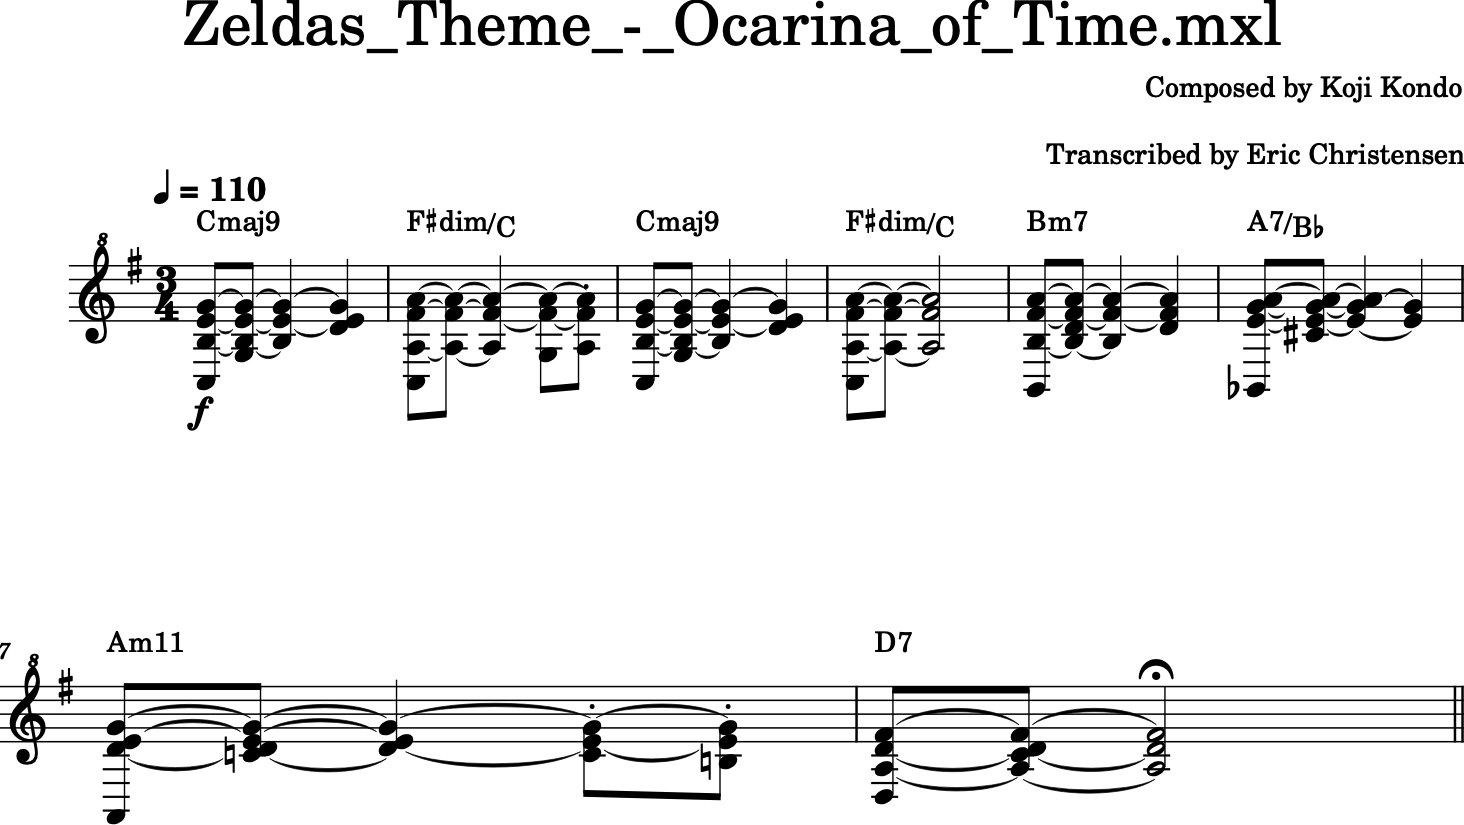

In [4]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Zeldas_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()


Now we're really getting somewhere! These are the exact symbols used in the "Best Collection" piano book for Zelda OOT as well as a set of other Zelda games. We have some extended harmony going on, and even some pretty tough to identify chord symbols like `F#dim/C`.

![alt text](./Images/ZeldasThemeScreenshot.png)

This Zelda music is a good test case because it has some colorful harmony going on, and follows our assumption of one chord per bar, which we can relax later on. If we run our script on the Main Theme, we'll see two complications that I'll deal with later. 

- Passing tones in the melody are causing the chord recognition to break. Notice how no symbols are generated for measures 5 or 7(This will be dealt with in the **Passing Tones** section)

- Should that be `Dm9/F`? Or `Fmaj13`? (Dealt with in the **13th chords** section)

Skipping measure 5 due to error: øb/fadde is not a supported accidental type
Skipping measure 7 due to error: øb/fadde is not a supported accidental type
Skipping measure 9 due to error: øb/fadde is not a supported accidental type
Skipping measure 11 due to error: øb/fadde is not a supported accidental type
Skipping measure 25 due to error: øb/fadde is not a supported accidental type
Skipping measure 27 due to error: øb/fadde is not a supported accidental type


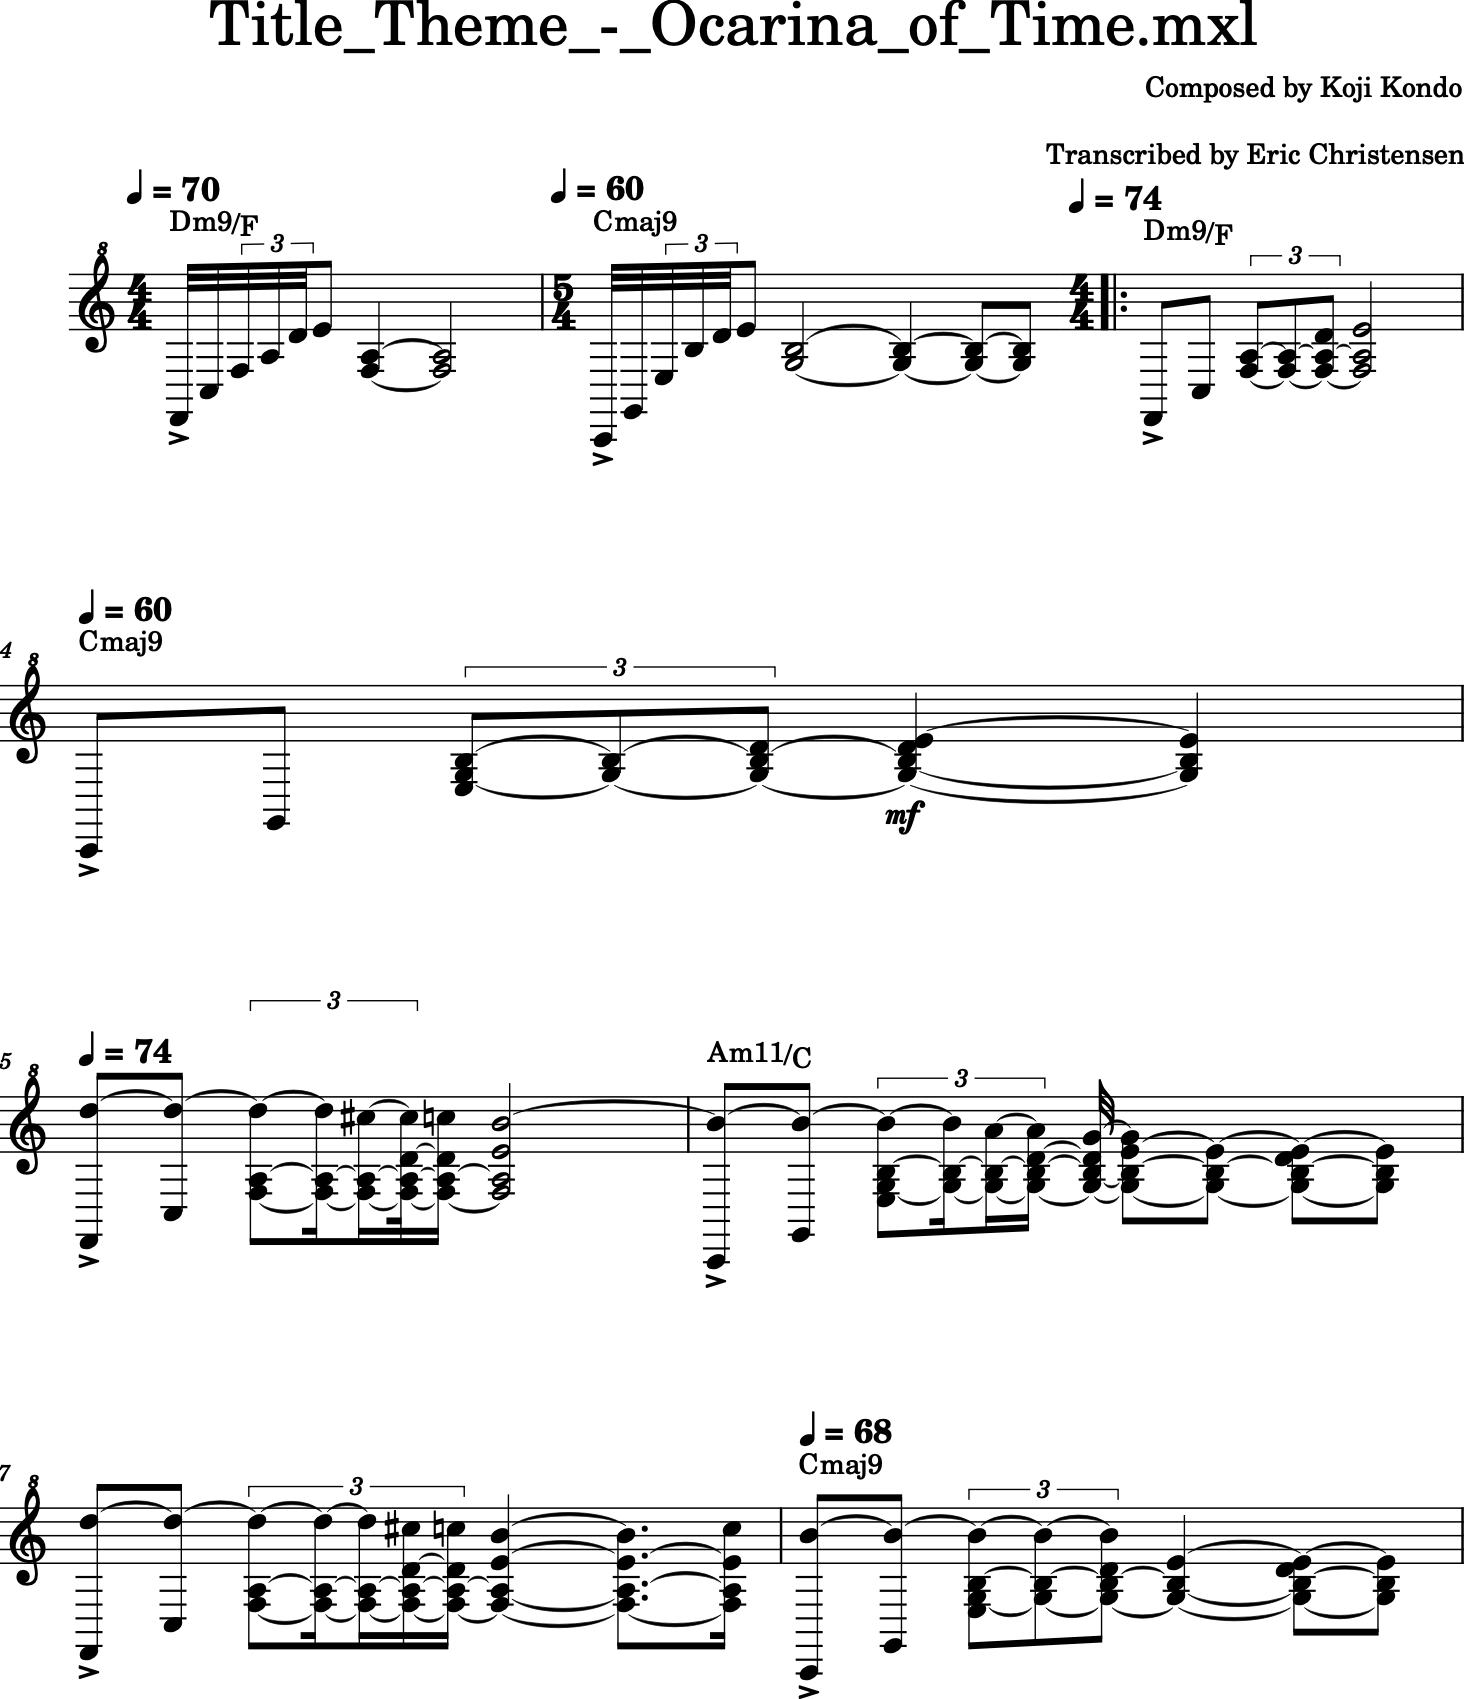

In [5]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Title_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)

select = chordified_score.measures(1,8)
select.show()


The town themes from the I Am Setuna also follow this "one chord per bar" assumption, and are written for solo piano, so they're easy to display. Let's append our chordified staff with chord symbols to the bottom of the score.

The formatting gets a little messed up from doing this, but the first two staves are RH and LH of the piano, and the third staff is the chordify reduction with calculated chord symbols.

Skipping measure 19 due to error: susaddc is not a supported accidental type
Skipping measure 34 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 35 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 39 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 40 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


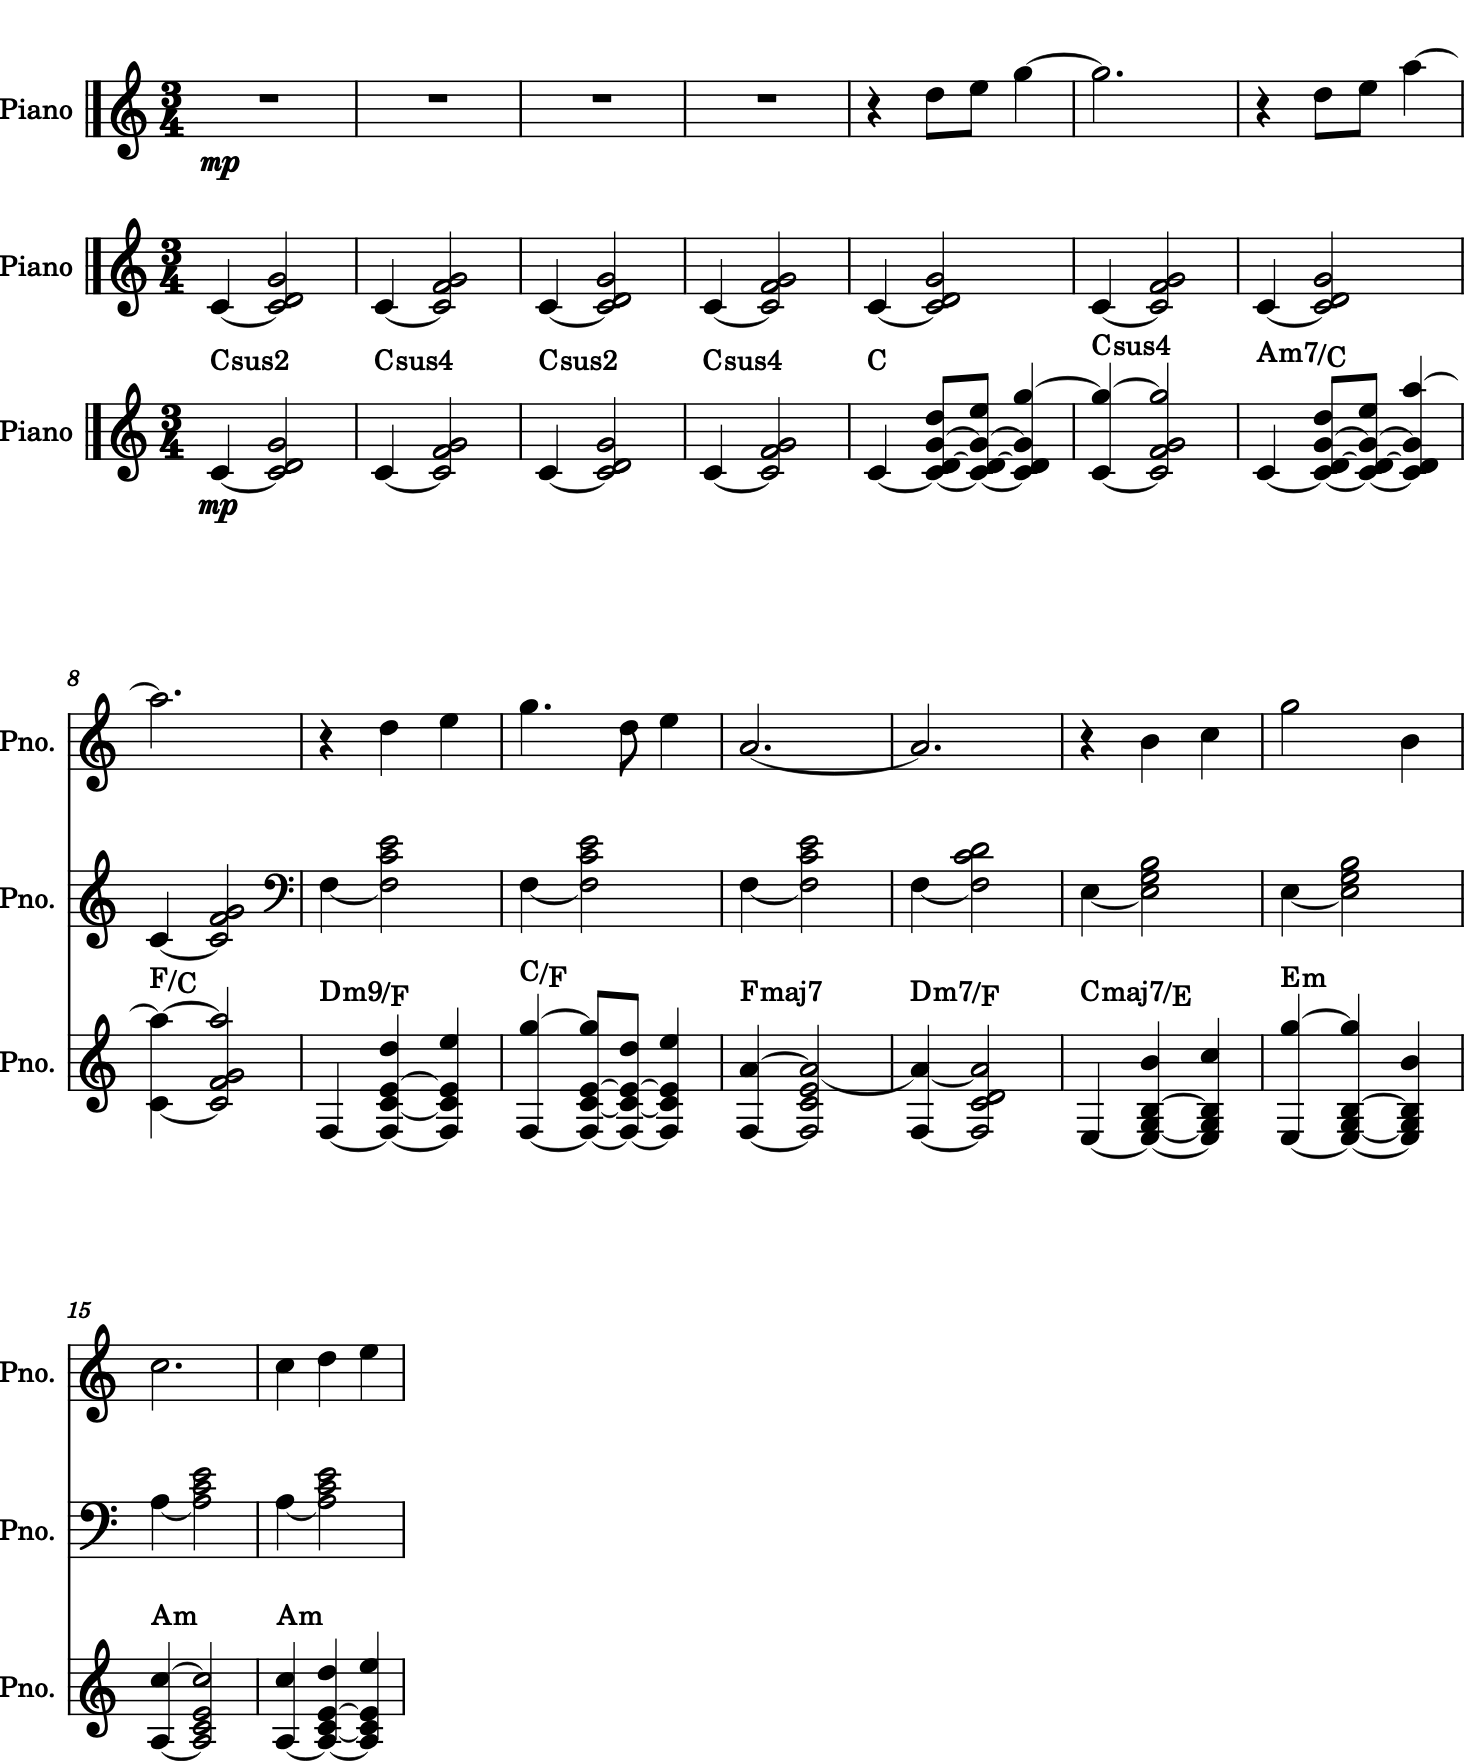

In [6]:
# Load the score from a MusicXML file
score = m21.converter.parse('./Setsuna_MXL/I Am Setsuna Piano Scores - 01_Piano - 03 Scent Of The Sea.musicxml')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    
    # Append the chordify staff to the original score
combined_score = m21.stream.Score()
for part in score.parts:
    combined_score.append(part)
combined_score.append(chordified_score) 

select = combined_score.measures(1,16)
select.show()


This other I Am Setsuna song shows another couple of error cases:
- In measure 8, there's a passing tone in the bass line that messes up chord symbol calculation
- Some measures are throwing an error because we're creating a chord that doesn't have any notes in it when it comes time to name them. Not sure what the cause of this is.
- Not sure what caused that rogue giant chord in the LH on measure 1
- In case it's confusing, this is a file where I had already manually added some chord symbols and Roman Numerals to the first two staves. Ignore those and pay attention to the third staff, whose symbols were automatically generated.

Skipping measure 3 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 8 due to error: /c#addb is not a supported accidental type
Skipping measure 17 due to error: maddf# is not a supported accidental type
Skipping measure 19 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 24 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 27 due to error: madde is not a supported accidental type
Skipping measure 36 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 39 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 40 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 43 due to error: no pitches in chord <music21.har

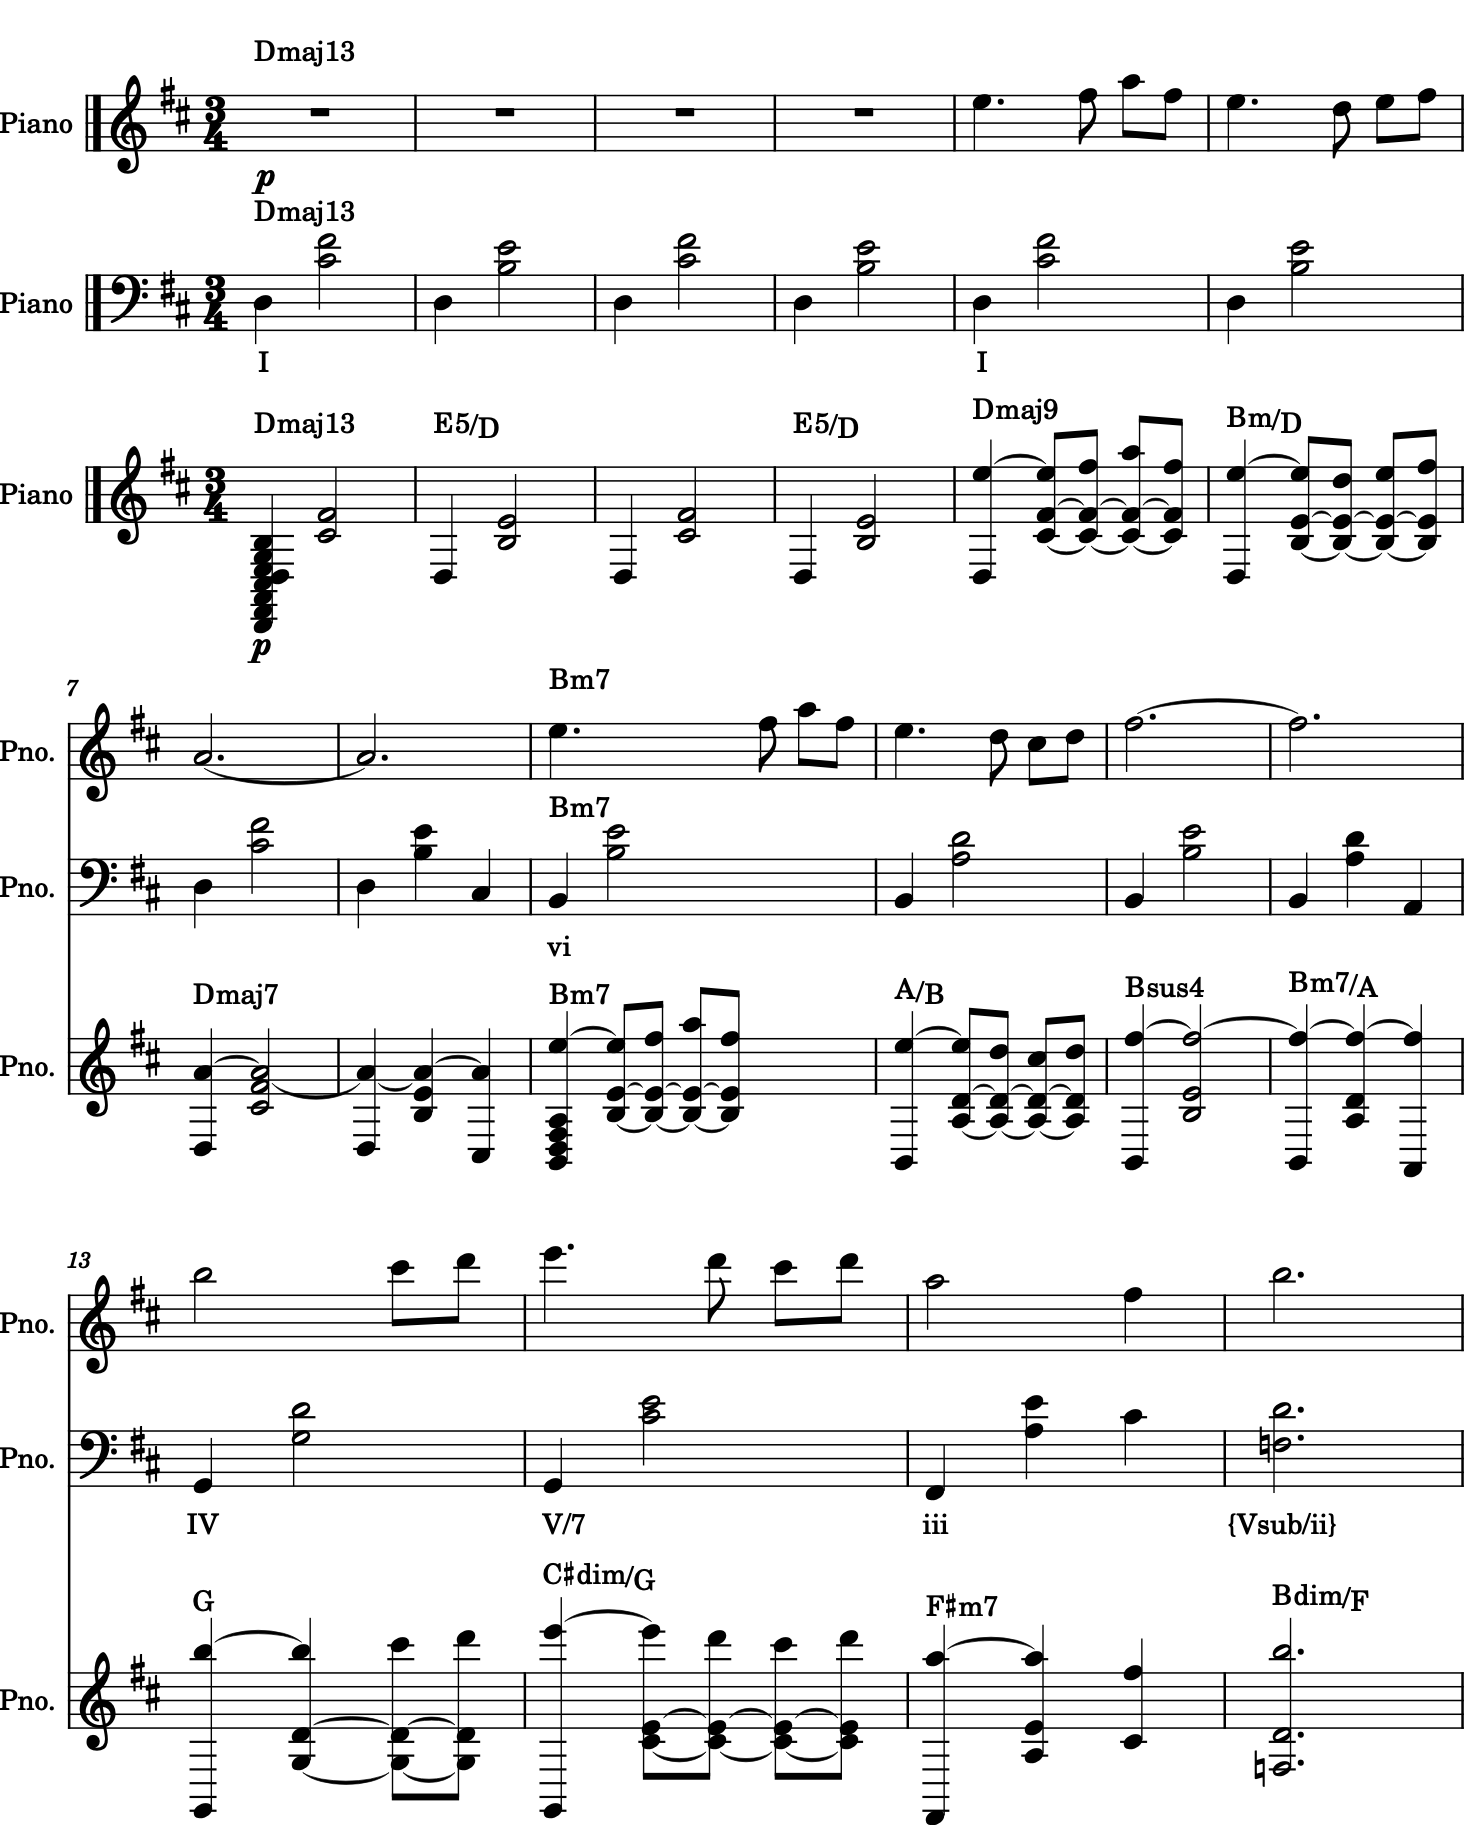

In [7]:
# Load the score from a MusicXML file
score = m21.converter.parse('./Setsuna_MXL/I am Setsuna - Tender Glow Analysis.musicxml')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    
    # Append the chordify staff to the original score
combined_score = m21.stream.Score()
for part in score.parts:
    combined_score.append(part)
combined_score.append(chordified_score) 

select = combined_score.measures(1,16)
select.show()


For orchestral scores, there's a lot more information, so we have a few display options:
 - Display the entire score with chord symbols
 - Add our `chordify()` score reduction with chord symbols as an additional staff at the bottom (as we've done with the I Am Setsuna examples)
 - Try and grab the melody and make a rough piano reduction with the melody on the RH staff, and the chordify() accompaniment on the LH staff (automatically producing a representative piano reduction like what an orchestration student might make would probably be a lot more difficult) 

**Entire score + chordify staff**

Skipping measure 16 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


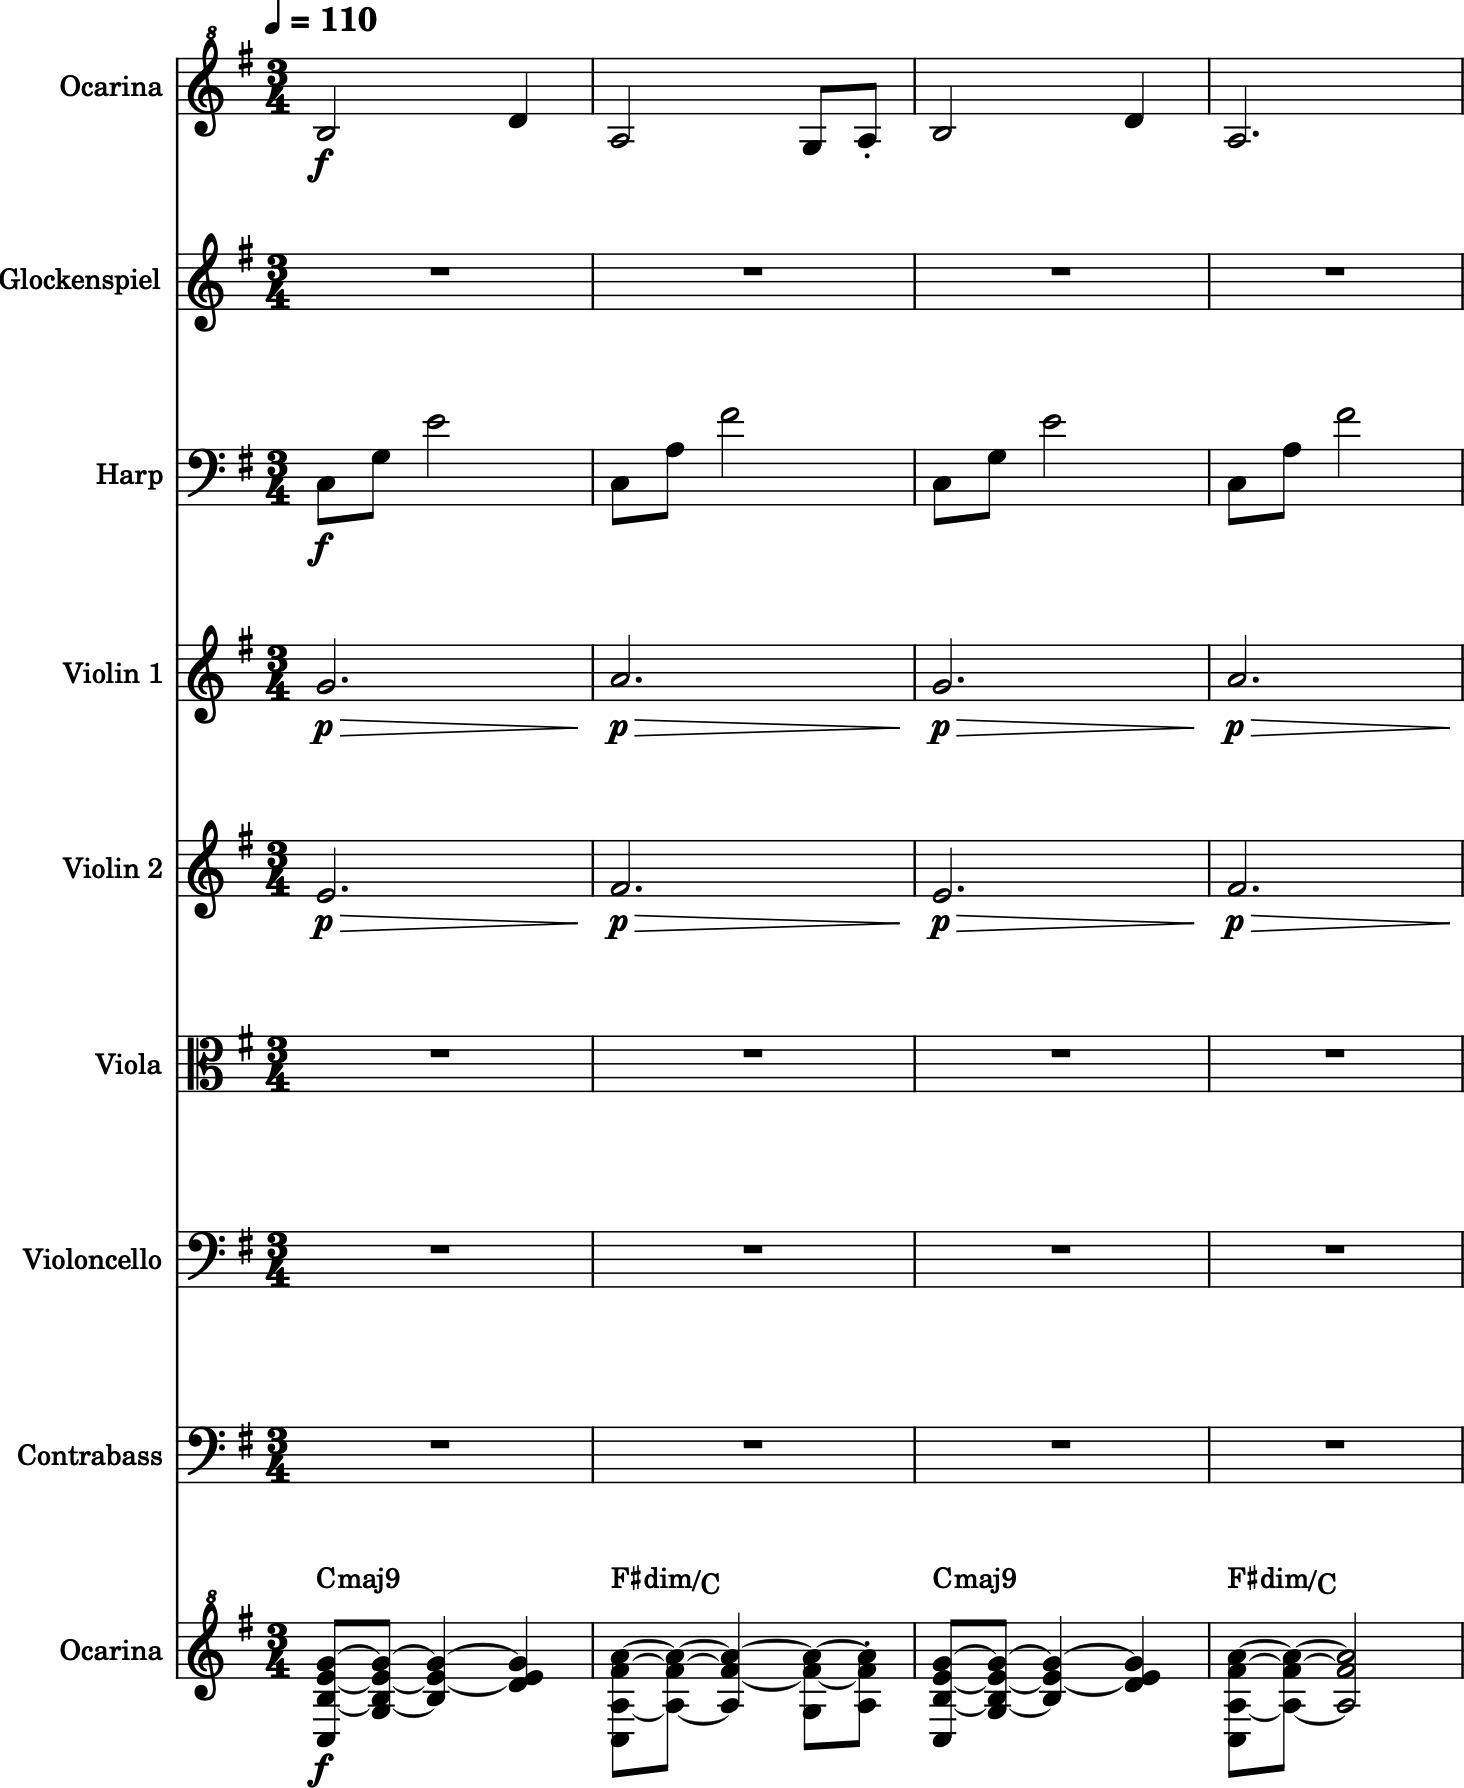

In [8]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Zeldas_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    
# Append the chordify staff to the original score
combined_score = m21.stream.Score()
for part in score.parts:
    combined_score.append(part)
combined_score.append(chordified_score) 

select = combined_score.measures(1,4)
select.show()

**Melody + chordify staff**

Because we are including the melody in the `chorify()` staff for chord calculation, we're technically displaying duplicate notes. In order to get around this, we'd have to make this staff including the melody, calculate the chord symbols, then make a new version with melody removed for appending onto the score.

Skipping measure 16 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


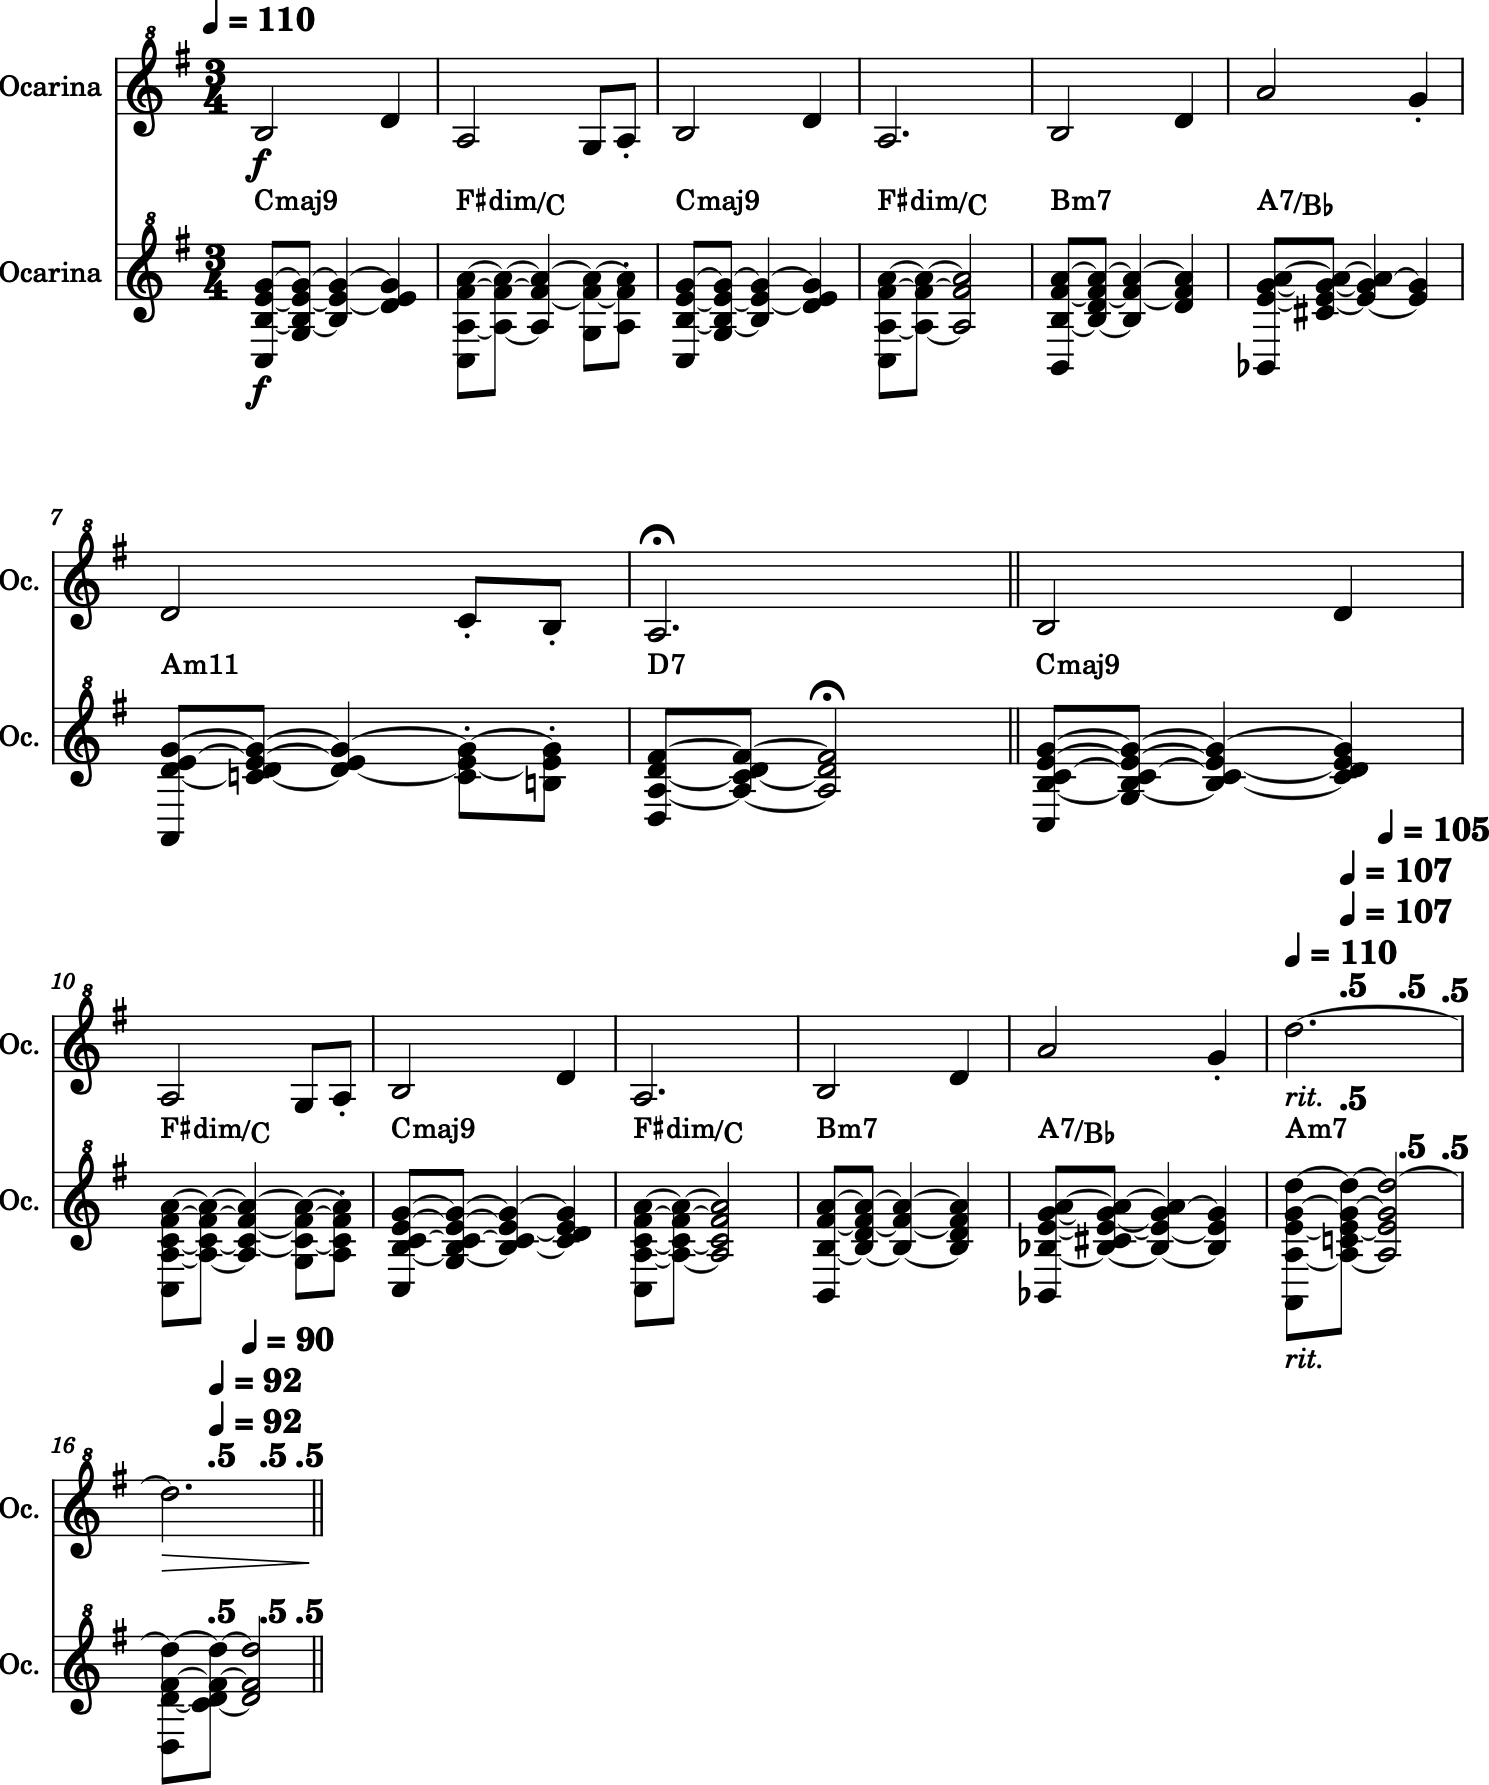

In [9]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Zeldas_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    
    # Append the chordify staff to the original score
combined_score = m21.stream.Score()
combined_score.append(score.parts[0])
combined_score.append(chordified_score) 

select = combined_score.measures(1,16)
select.show()

<h1>Passing Tones</h1>

The OOT Title theme is a great example for testing how we want to handle passing tones. As we saw above, the ocarina melody introduces some half steps that mess up the chord naming. See the Db in measure 5.

Skipping measure 5 due to error: øb/fadde is not a supported accidental type
Skipping measure 7 due to error: øb/fadde is not a supported accidental type
Skipping measure 9 due to error: øb/fadde is not a supported accidental type
Skipping measure 11 due to error: øb/fadde is not a supported accidental type
Skipping measure 25 due to error: øb/fadde is not a supported accidental type
Skipping measure 27 due to error: øb/fadde is not a supported accidental type


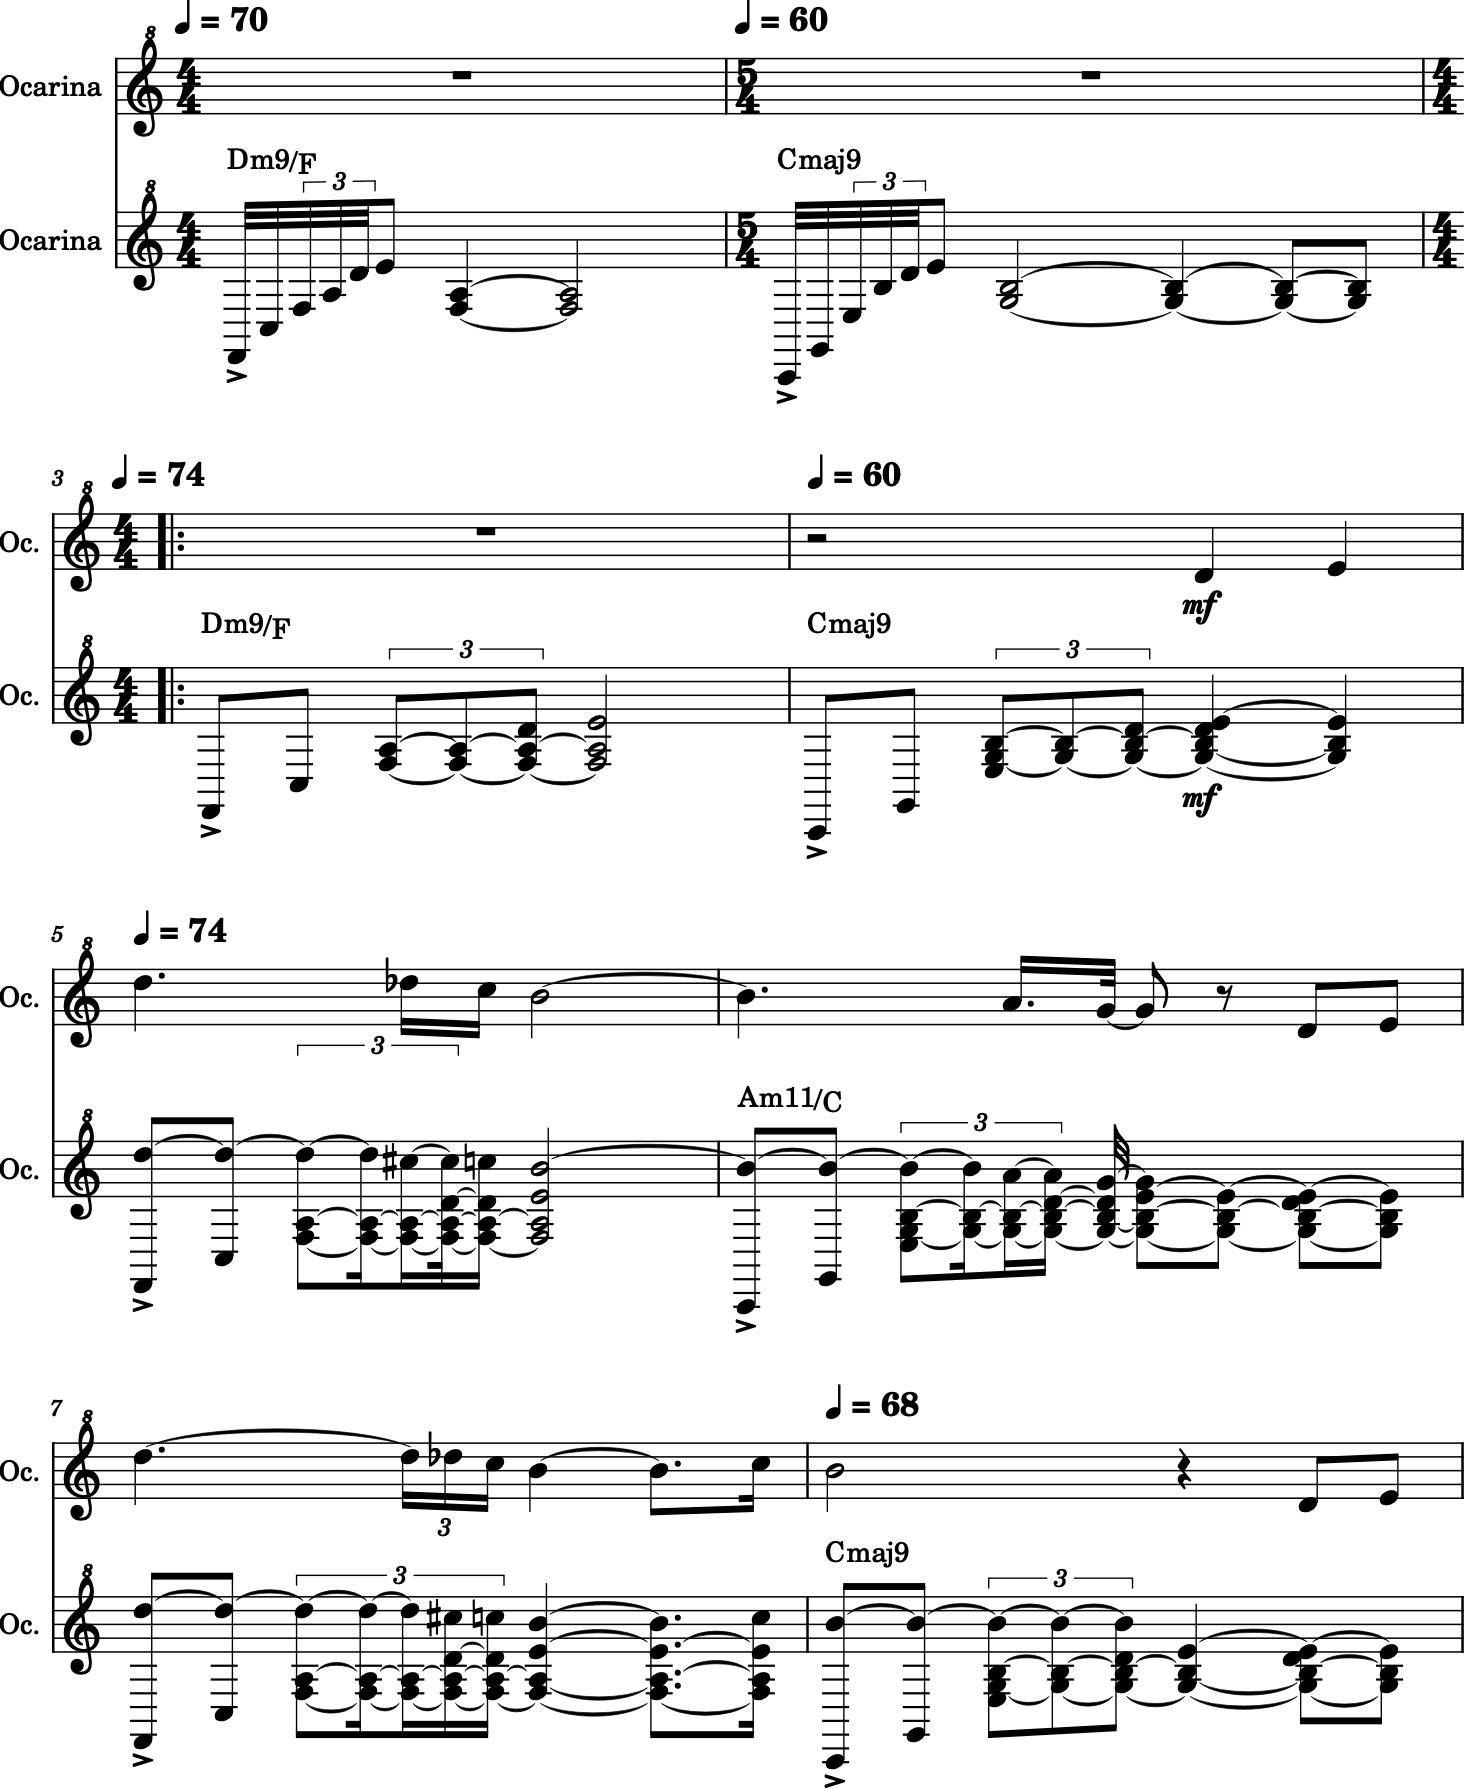

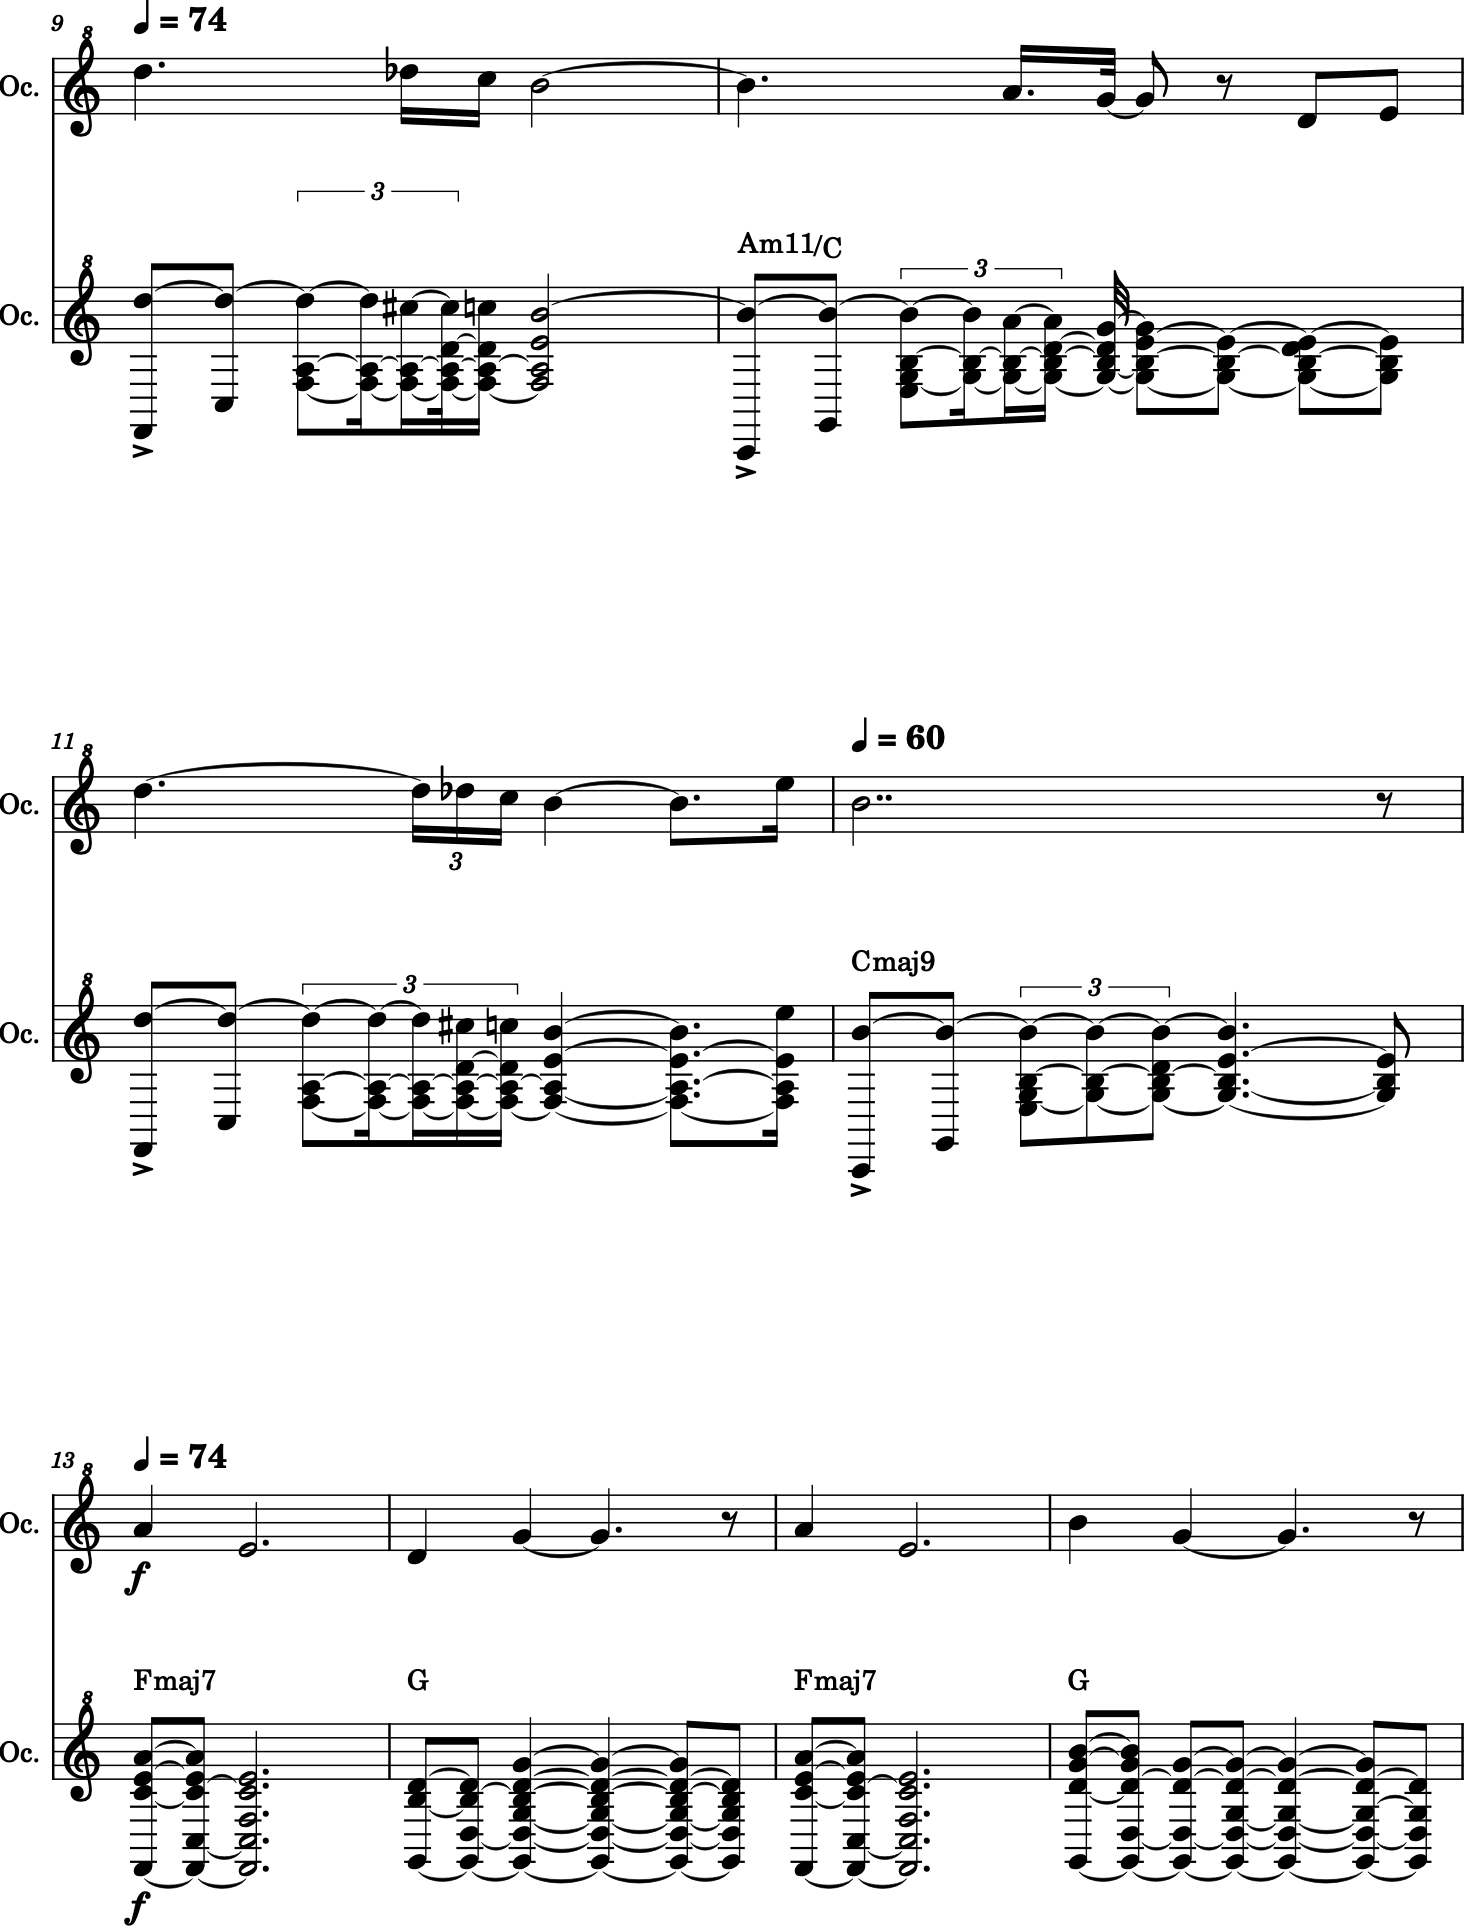

In [10]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Title_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    
    # Append the chordify staff to the original score
combined_score = m21.stream.Score()
combined_score.append(score.parts[0])
combined_score.append(chordified_score) 

select = combined_score.measures(1,16)
select.show()

We could filter such examples by not counting 16th notes and other short durations as part of the harmony. However, doing so here would filter out those piano chords that are quickly being built up at the beginning of measures 1 and 2. Similarly, if we have an accompaniment figure that's doing arpeggios as 16th notes or even 32nd notes, we want to catch that as a harmonic gesture. For now, my solution is to check series of short notes, and count them as part of harmonic analysis if the sum of their value is a quarter note or more. This filters out the passing tone in measure 5, but not the chords in measures 1 & 2.

This is still vulnerable to scale or chromatic runs lasting longer than a quarter note, but otherwise seems to deal with the edge case well. In the below function, I specify `threshold`, the note duration under which we consider a note a short note , as a 16th note (i.e. 0.25 or a quarter note), and `cumulative_threshold`, the cumulative duration of the short notes required for them to be considered as part of the harmony, as a quarter note (`quarterLength = 1.0`).

In [11]:
def filter_weighted_duration(notes, threshold=0.25, cumulative_threshold=1.0):
    """Filters out short notes unless their cumulative duration exceeds a threshold."""
    filtered_notes = []
    short_notes = []
    
    for note in notes:
        if note.quarterLength > threshold:  # Longer notes are directly included
            if sum(n.quarterLength for n in short_notes) >= cumulative_threshold:
                filtered_notes.extend(short_notes)  # Include short notes if cumulative duration is enough
            short_notes = []  # Reset short notes collection
            filtered_notes.append(note)
        else:
            short_notes.append(note)
    
    # Check the last batch of short notes
    if sum(n.quarterLength for n in short_notes) >= cumulative_threshold:
        filtered_notes.extend(short_notes)  # Include the group of short notes if cumulative duration is enough
    
    return filtered_notes

def generate_chord_symbols_from_chordify(score, threshold=0.25, cumulative_threshold=1.0):
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()
    
    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all chords/notes in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)
        
        # Apply the filter to exclude passing tones
        filtered_notes = filter_weighted_duration(notes_in_measure,threshold,cumulative_threshold)
        
        if filtered_notes:
            # Create a chord from all filtered notes in the measure
            combined_chord = m21.chord.Chord(filtered_notes)
            
            try:
                # Attempt to generate a chord symbol
                chord_symbol = m21.harmony.ChordSymbol()
                chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                
                # Ensure the chord symbol has a valid root
                if not chord_symbol.root():
                    raise ValueError("Invalid root note in chord symbol.")
                
                # Insert the ChordSymbol into the measure at the beginning
                measure.insert(0, chord_symbol)
                
            except Exception as e:
                # Skip the measure if an error occurs
                print(f"Skipping measure {measure.number} due to error: {e}")
    
    return chordified_score

It turns out that those quick chord gestures in measures 1 & 2 are actually only an 8th note in cummulative duration, and thus are correctly filtered out, so measure 1 only has pitches F-A-E, and measure 2 only has pitches G-B-E get past filtering.

I'm ok with this. Honestly, these chords should probably be notated as half notes with arpeggiation symbols instead of having the arpeggiation written out like this.

Skipping measure 1 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


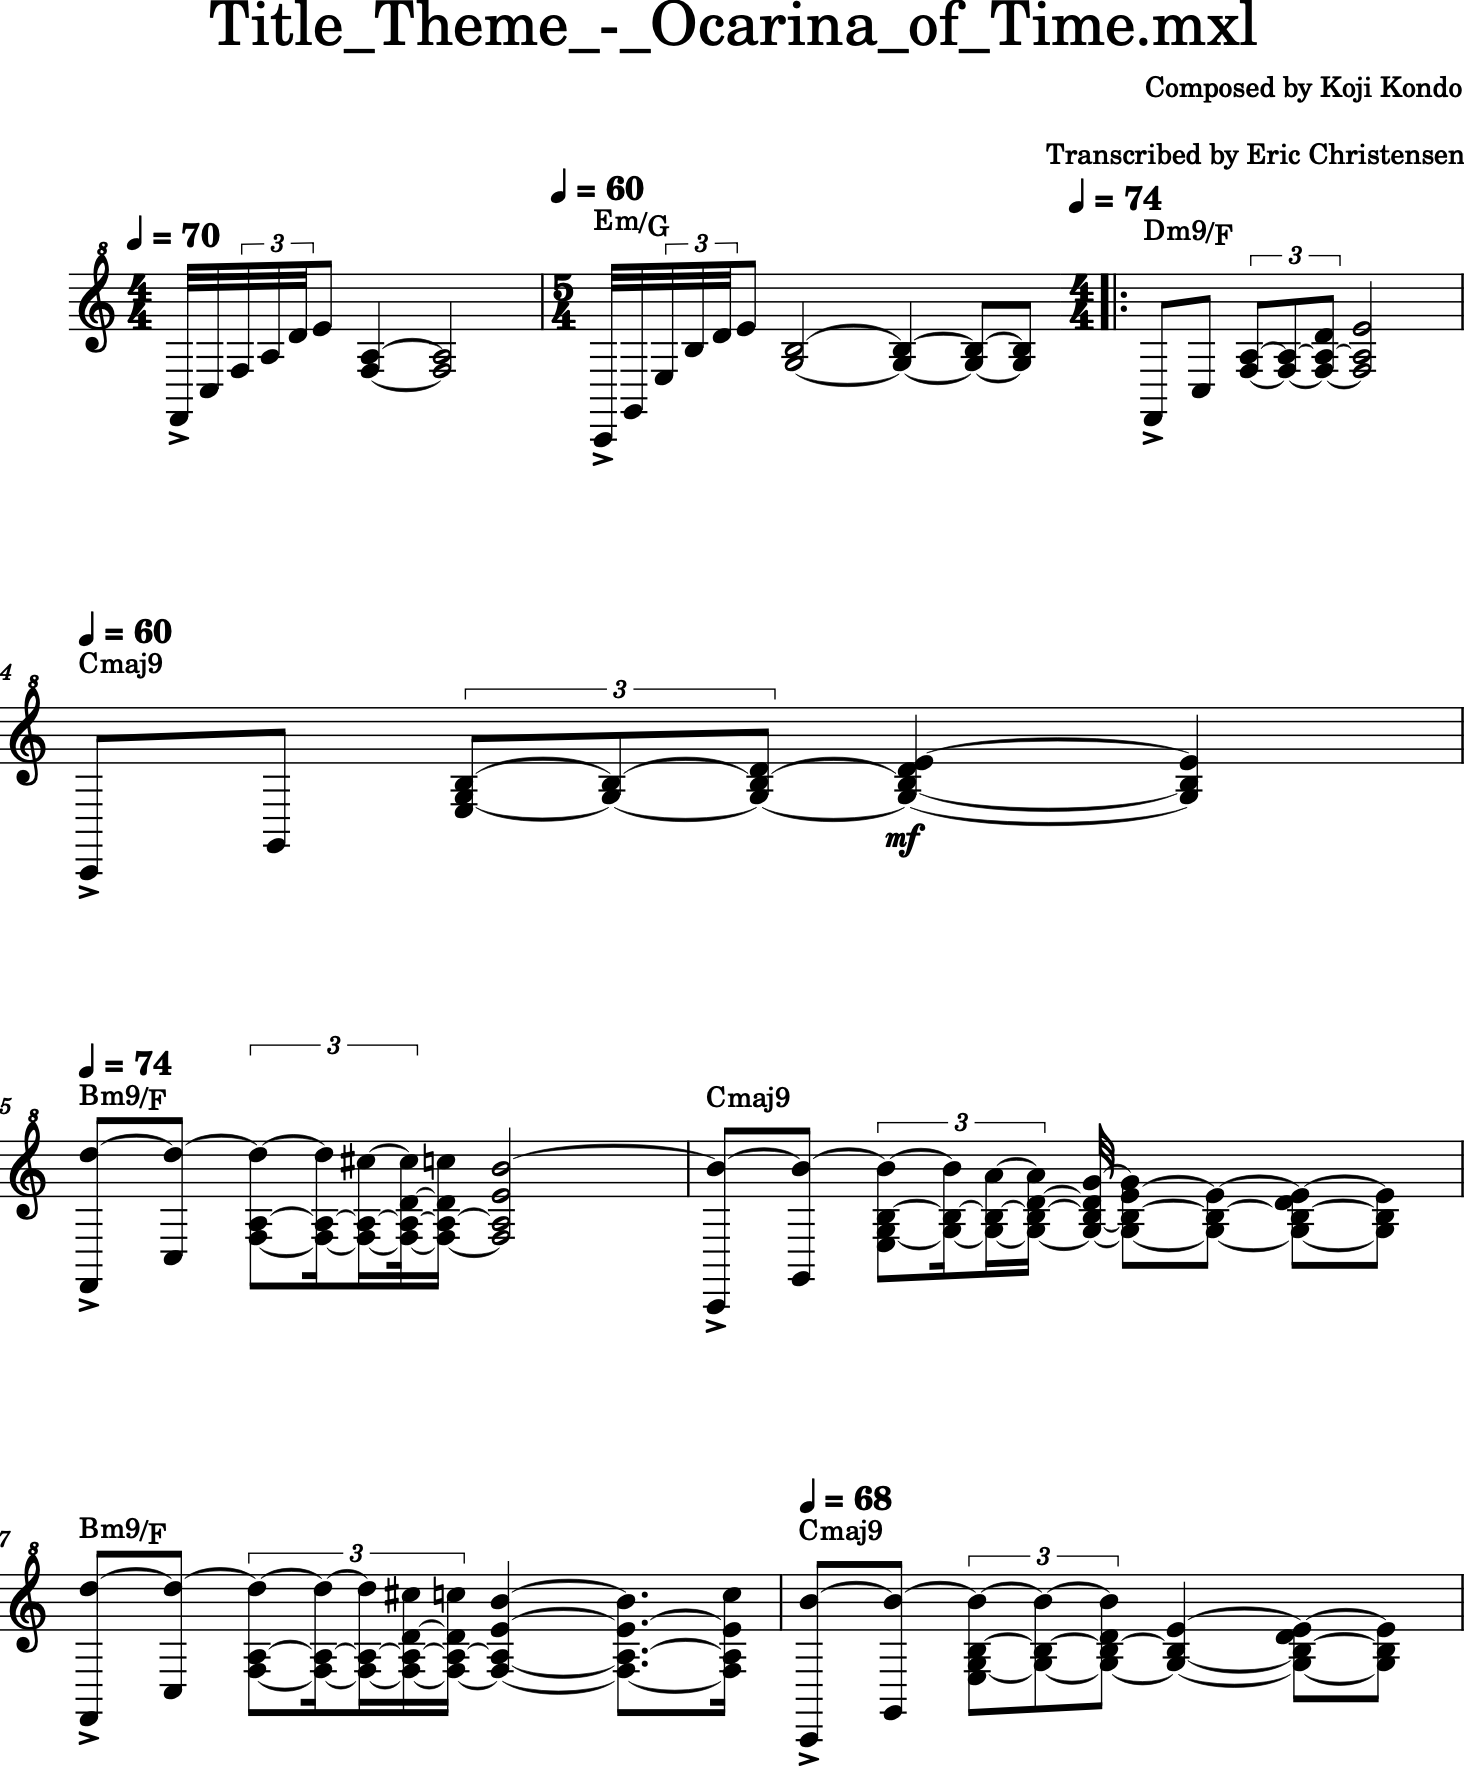

In [12]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Title_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()

Now measures 5, 7, 9, etc. that have the passing tone in the ocarina melody didn't throw an error in chord symbol generation.

Now we've got something fairly robust that should be able to cover a range of songs.

On Kakariko Village, all seems to be well, although the chord identifier throws an error trying to identify this recurring C-G-Bb-F chord, which because of the 16251 structure, a jazz musician would probably interpret as a Cm7 without the third or a Csus7 that's functioning as the `ii` chord. This is because the music21 chord identifier needs the 3rd and 5th to identify the root of the chord. A similar edge case detailed in the docs is that 7th chords with the 5th removed (also common in jazz influenced genres) also throw an error in chord identification. 


Skipping measure 3 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 7 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 11 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 14 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 23 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 27 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 30 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 39 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 44 due to error: no pitches in chord <mus

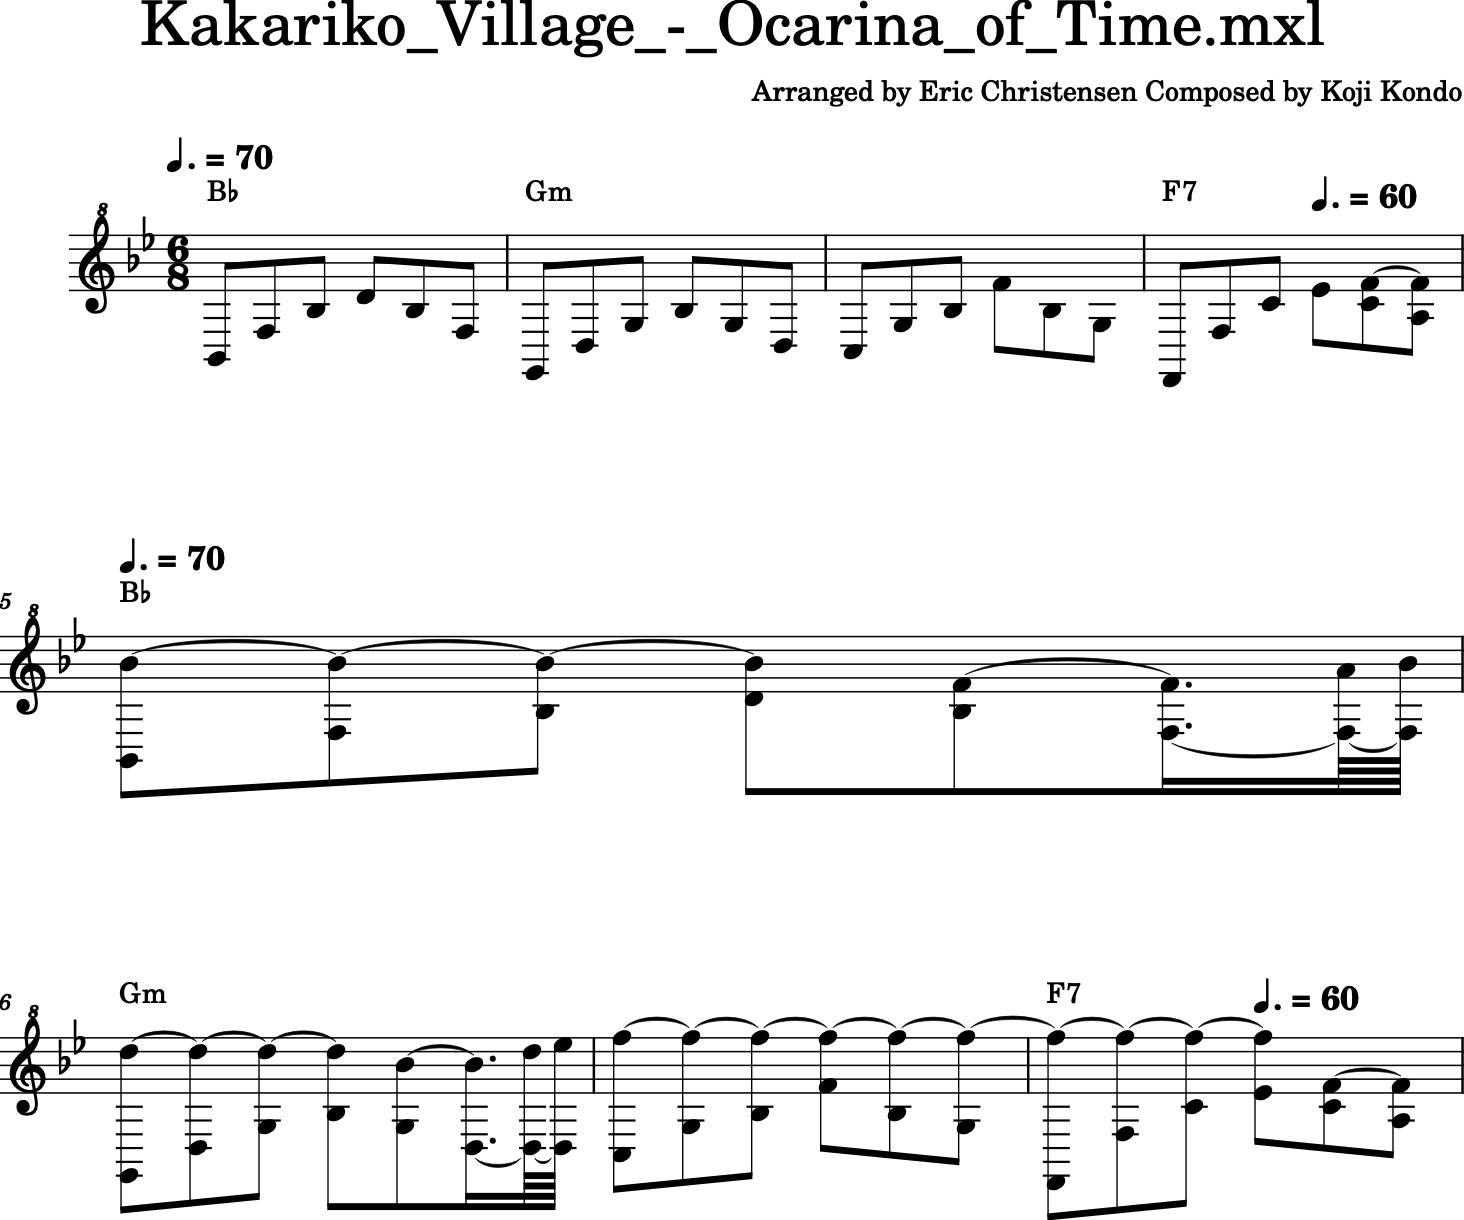

In [13]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Kakariko_Village_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()

As we'll discuss in the `13th chords` section, jazz influenced genres tend to put the root of the chord in the bass a lot more often than in classical styles, so we may be able to get around these edge cases by making some assumptions. If we assume the bass note is the root for this chord, it should properly label this chord as Csus7.

Once the root identification problem is accounted for, we can also use ⁠`music21.harmony.addNewChordSymbol()` ⁠to add a new chord type to the chord identifier's chord type dictionary. We could use it, for instance to add types like `C7(no 5th)`.

Let's try and modify the script to try setting the lowest note as the root in cases like this. See the new try-except block I added to the bottom.

In [14]:
def generate_chord_symbols_from_chordify(score, threshold=0.25, cumulative_threshold=1.0):
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()
    
    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all chords/notes in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)
        
        # Apply the filter to exclude passing tones
        filtered_notes = filter_weighted_duration(notes_in_measure,threshold,cumulative_threshold)
        
        if filtered_notes:
            # Create a chord from all filtered notes in the measure
            combined_chord = m21.chord.Chord(filtered_notes)
            
            try:
                # Attempt to generate a chord symbol
                chord_symbol = m21.harmony.ChordSymbol()
                chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                
                # Ensure the chord symbol has a valid root
                if not chord_symbol.root():
                    raise ValueError("Invalid root note in chord symbol.")
                
                # Insert the ChordSymbol into the measure at the beginning
                measure.insert(0, chord_symbol)
                
            except Exception as e:
                #if returning an error, try setting the root to the lowest note of the chord
                try:
                    #set bass note as root of the chord
                    combined_chord.root(combined_chord.bass())

                    # Attempt to generate a chord symbol
                    chord_symbol = m21.harmony.ChordSymbol()
                    chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                    
                    # Ensure the chord symbol has a valid root
                    if not chord_symbol.root():
                        raise ValueError("Invalid root note in chord symbol.")
                    
                    # Insert the ChordSymbol into the measure at the beginning
                    measure.insert(0, chord_symbol)

                except Exception as e:
                    # Skip the measure if an error occurs
                    print(f"Skipping measure {measure.number} due to error: {e}")
    
    return chordified_score

This fixes our problem with the Csus7, although some issues in measures 14 and 30 still come up.

Skipping measure 14 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 30 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


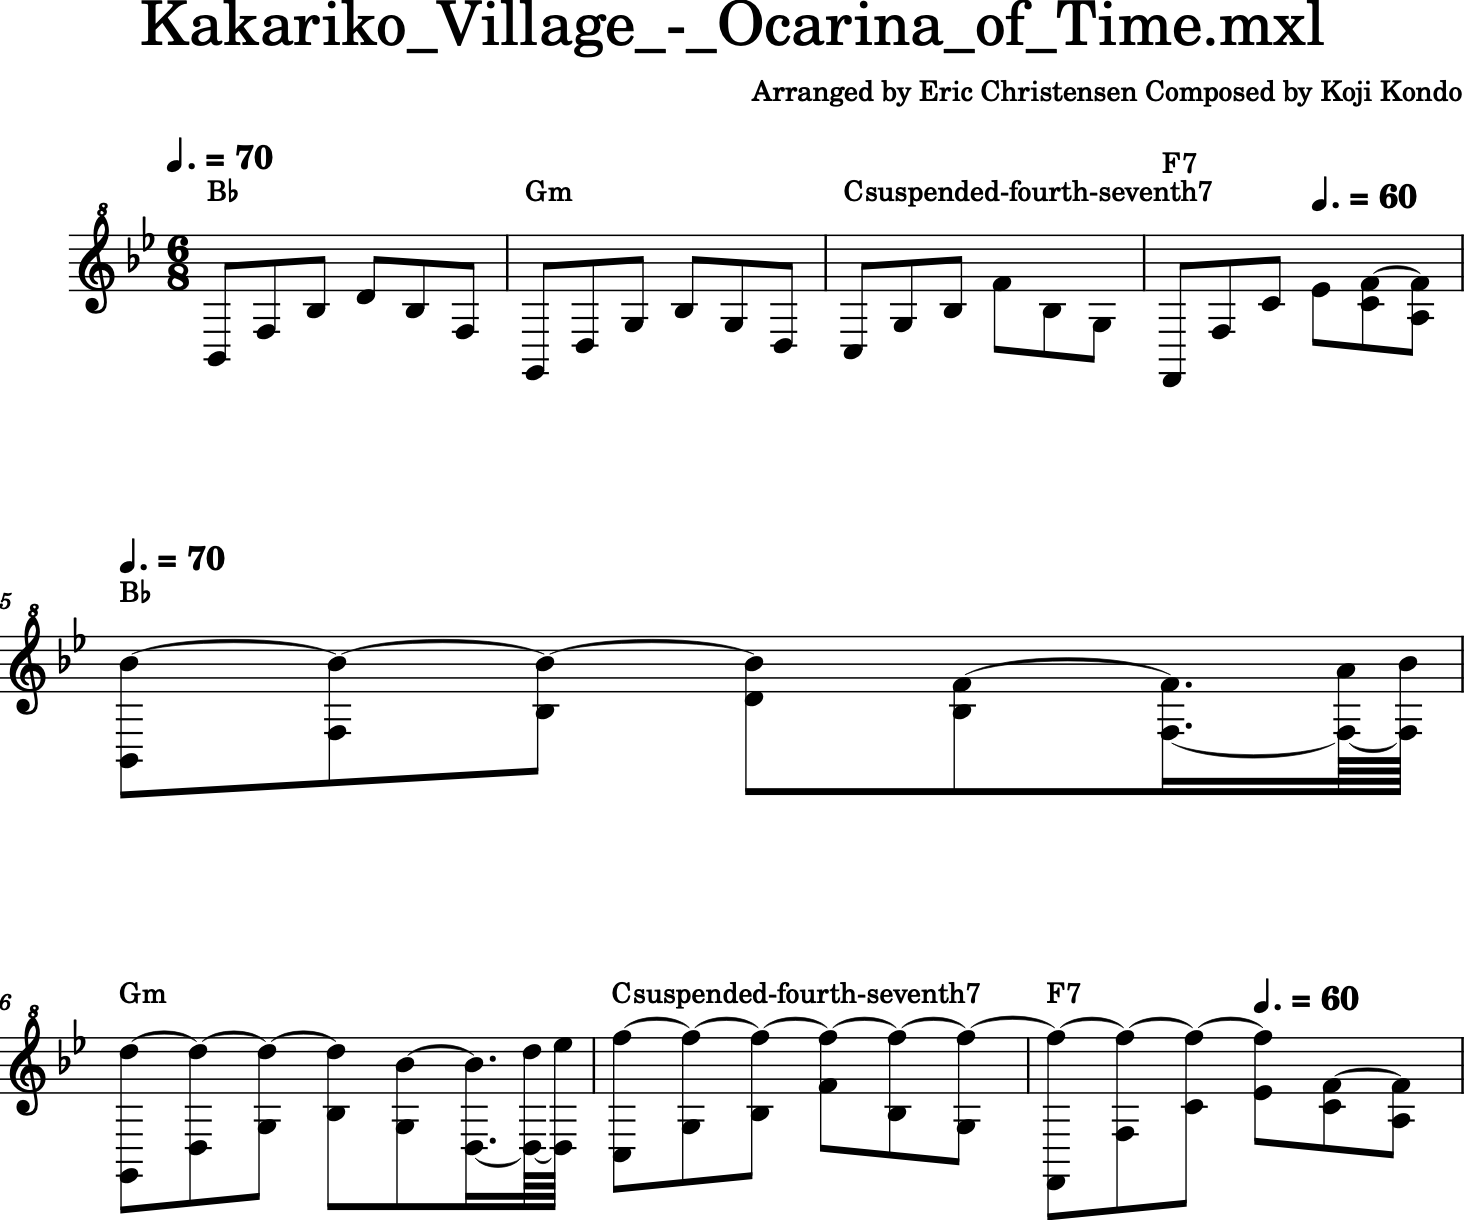

In [15]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Kakariko_Village_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()

In the case of measure 14, it can't identify a chord because everyone is just playing F and A. Instead of inferring from context like a musican might that the chord for this measure is an F major, making this set of measures `IV V I vi`, the tool thows an error because technically the current explicit chord is just a major 3rd between F and A. We could get around such cases by simply adding chord types for 2 note chordioids (I think this is the music theory term for that). Measure 30 is just a repeat of measure 14. 

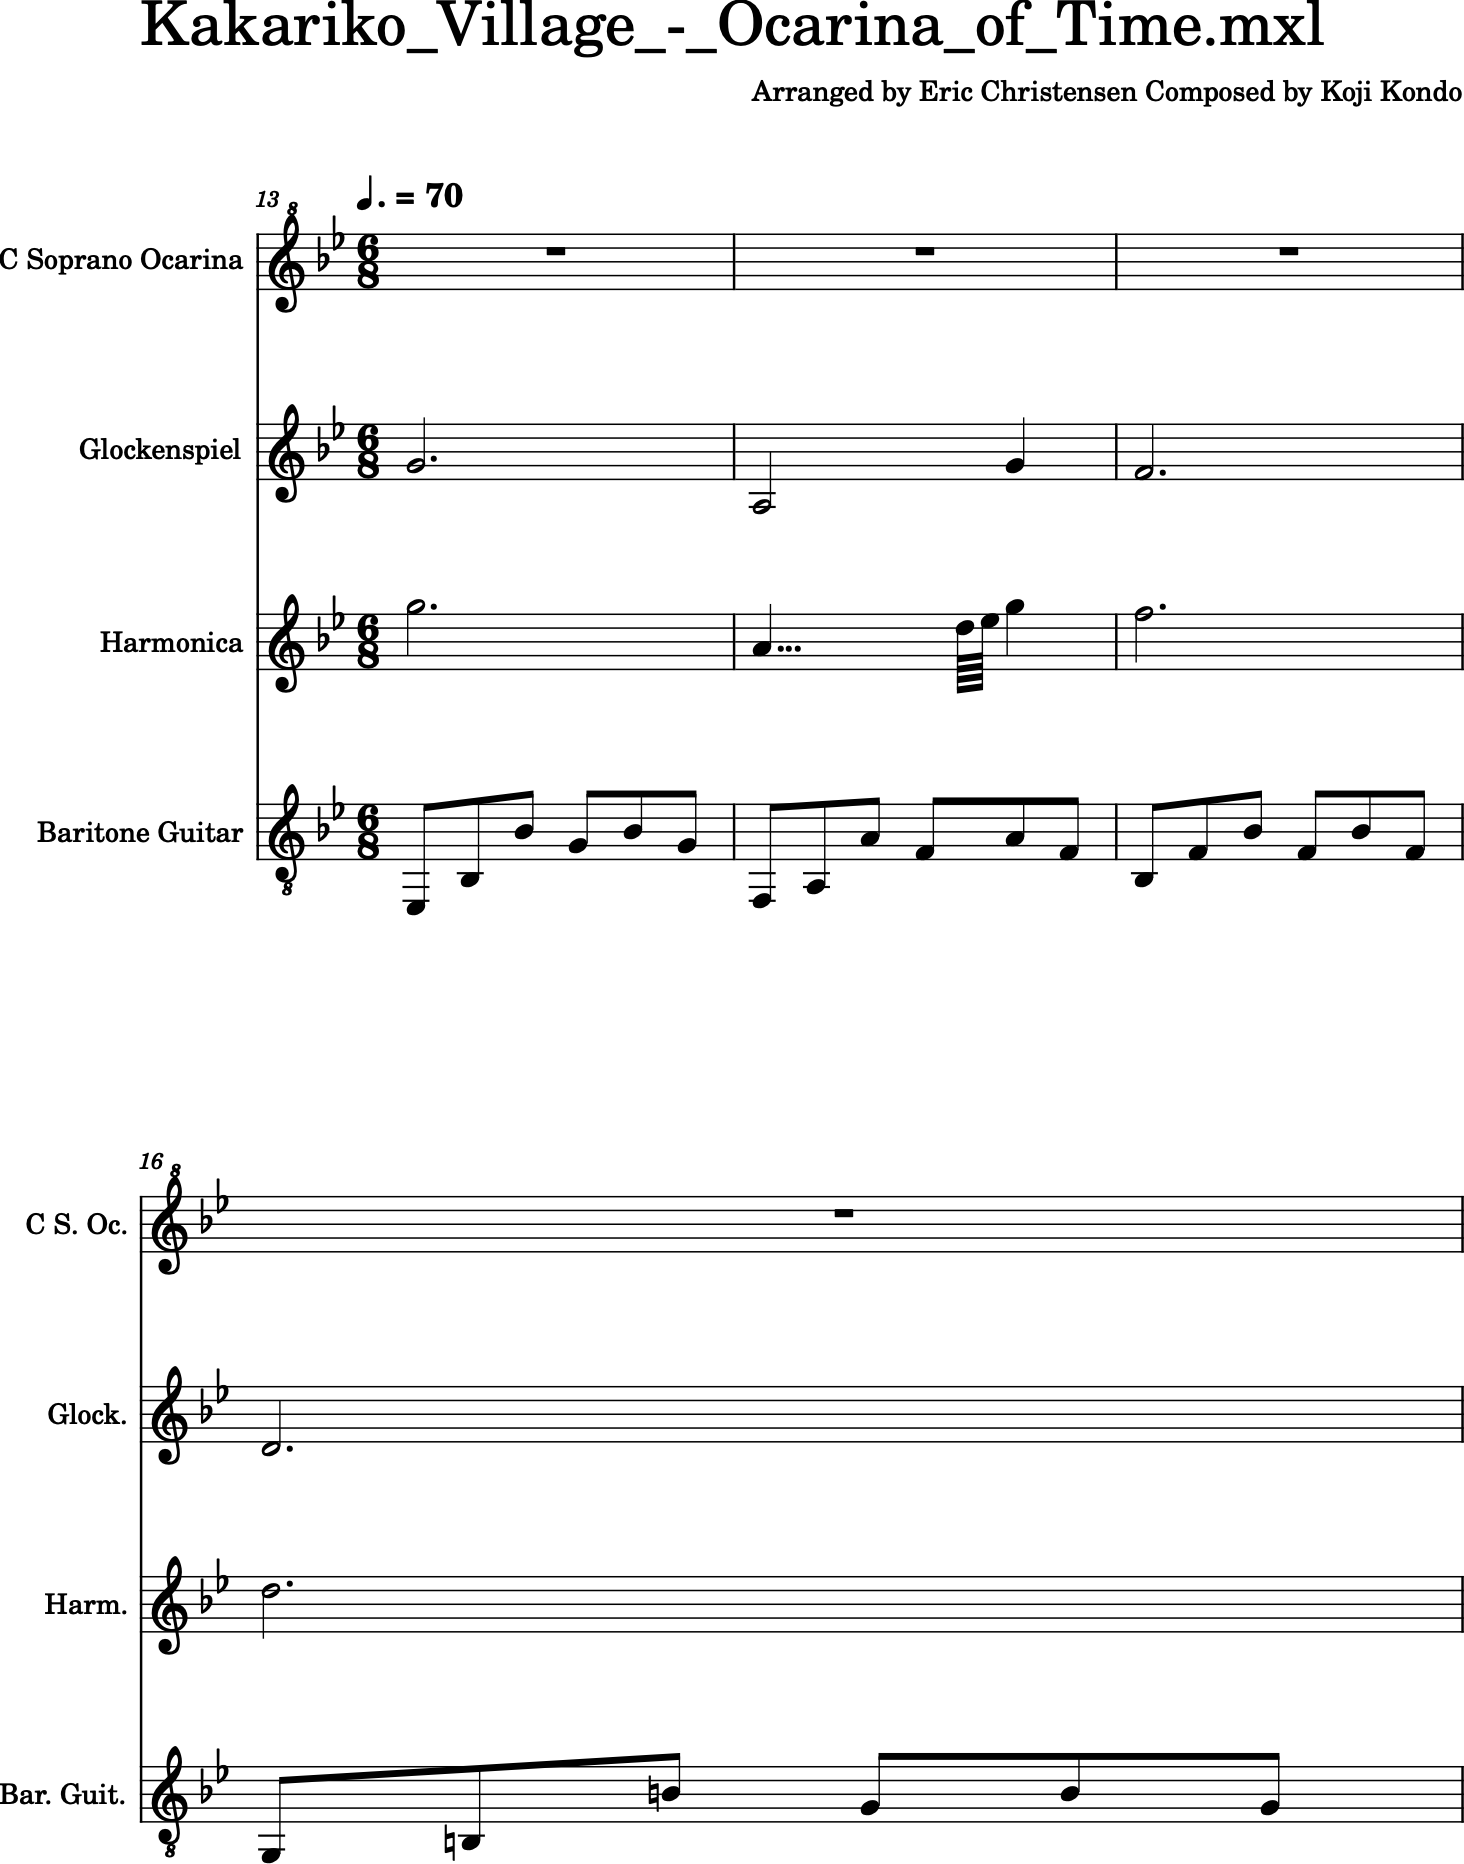

In [16]:
score.measures(13,16).show()

The Lost Woods theme has a tamborine part, and since its notes are unpitched, it will mess up our chord analysis.

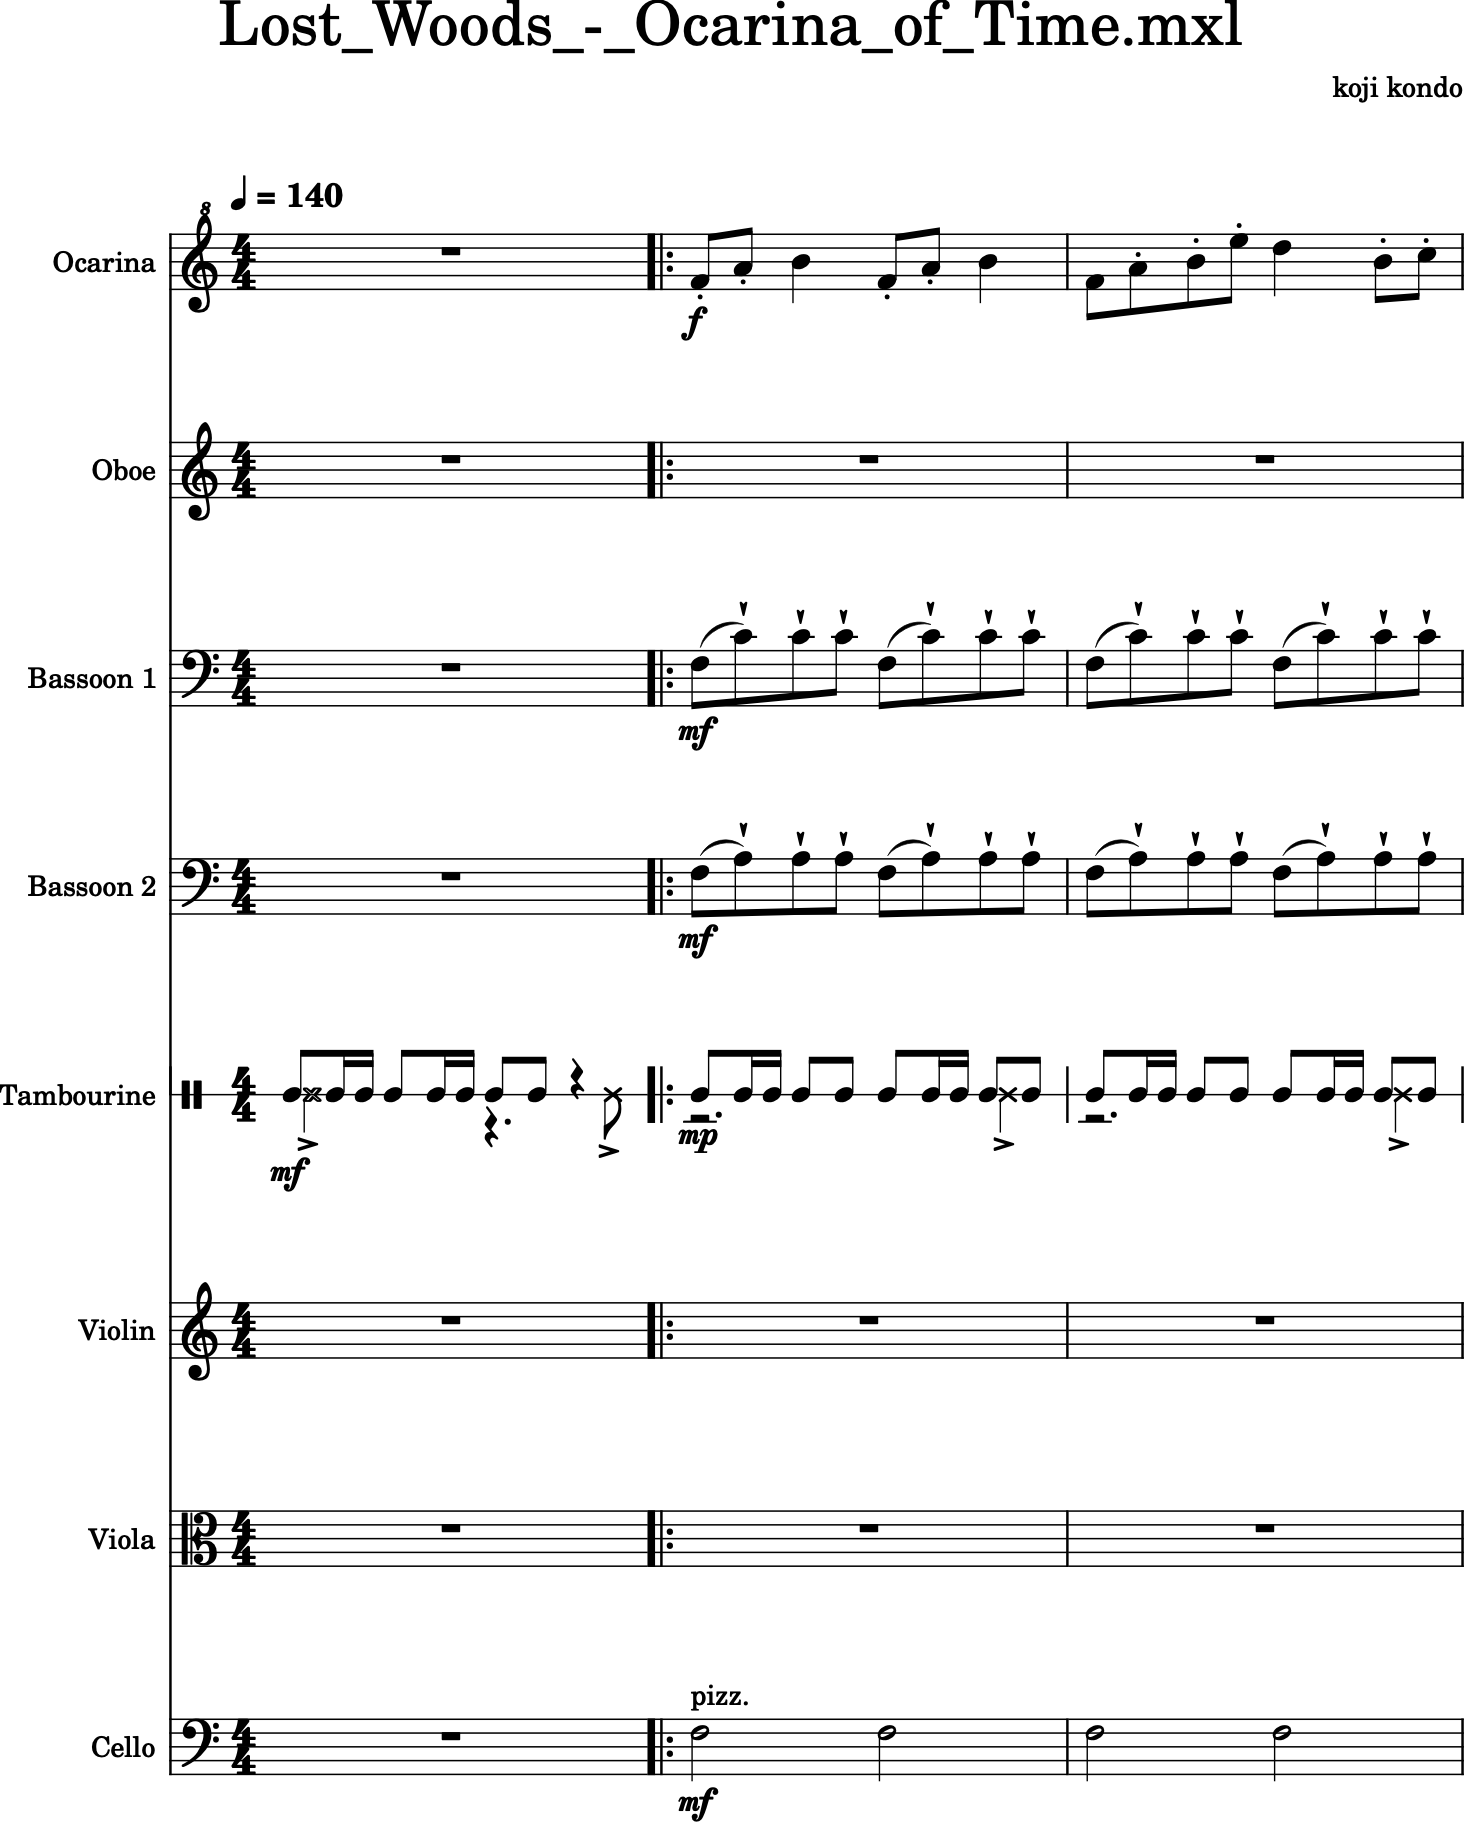

In [379]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Lost_Woods_-_Ocarina_of_Time.mxl')    

select = score.measures(1,3)
select.show()

Let's filter out parts with unpitched material before we call `chordify()`.

In [17]:
def remove_unpitched_parts(score):
    """Remove unpitched parts from the score to avoid issues with chordify."""
    parts_to_keep = []
    
    for part in score.parts:
        # Check if the part contains any pitched notes
        contains_pitched_notes = any(isinstance(element, m21.note.Note) and not isinstance(element, m21.note.Unpitched) for element in part.flatten().notes)
        
        if contains_pitched_notes:
            parts_to_keep.append(part)
    
    return m21.stream.Score(parts_to_keep)

def generate_chord_symbols_from_chordify(score, threshold=0.25, cumulative_threshold=1.0):
    
    # Remove unpitched parts before chordification
    score = remove_unpitched_parts(score)
    
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()
    
    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all chords/notes in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)
        
        # Apply the filter to exclude passing tones
        filtered_notes = filter_weighted_duration(notes_in_measure,threshold,cumulative_threshold)
        
        if filtered_notes:
            # Create a chord from all filtered notes in the measure
            combined_chord = m21.chord.Chord(filtered_notes)
            
            try:
                # Attempt to generate a chord symbol
                chord_symbol = m21.harmony.ChordSymbol()
                chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                
                # Ensure the chord symbol has a valid root
                if not chord_symbol.root():
                    raise ValueError("Invalid root note in chord symbol.")
                
                # Insert the ChordSymbol into the measure at the beginning
                measure.insert(0, chord_symbol)
                
            except Exception as e:
                #if returning an error, try setting the root to the lowest note of the chord
                try:
                    #set bass note as root of the chord
                    combined_chord.root(combined_chord.bass())

                    # Attempt to generate a chord symbol
                    chord_symbol = m21.harmony.ChordSymbol()
                    chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                    
                    # Ensure the chord symbol has a valid root
                    if not chord_symbol.root():
                        raise ValueError("Invalid root note in chord symbol.")
                    
                    # Insert the ChordSymbol into the measure at the beginning
                    measure.insert(0, chord_symbol)

                except Exception as e:
                    # Skip the measure if an error occurs
                    print(f"Skipping measure {measure.number} due to error: {e}")
    
    return chordified_score

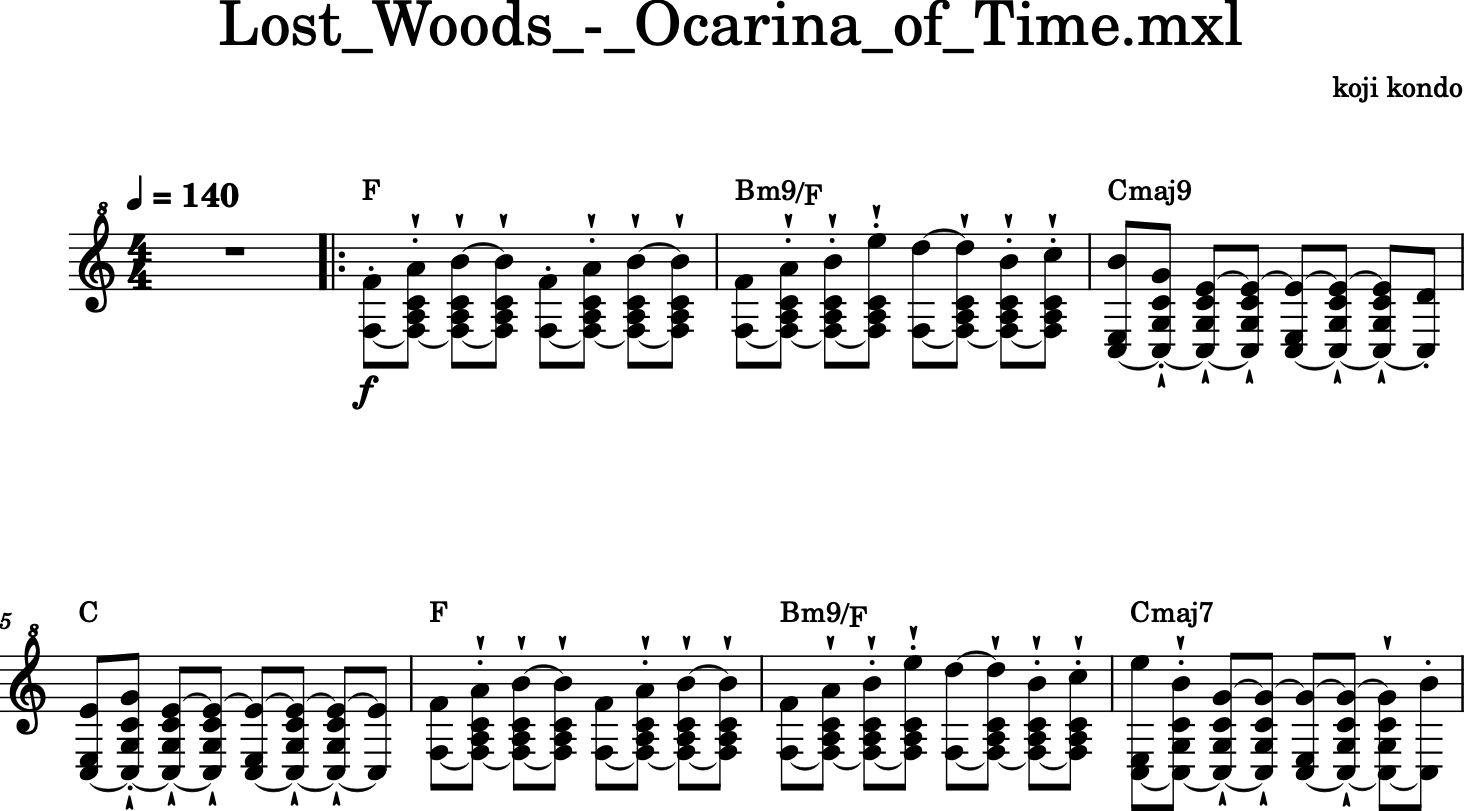

In [18]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Lost_Woods_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()

Great, so we've dealt with the tamborine. The `Bm9/F` symbol for what would technically be an `Fmaj7(#11,13)` is a bit of an odd symbol. This is partially because the chord identifier script **does** permit 9th chords with no 5th in them, which is the case for the proposed `Bm9/F` here because there is no F#. `Bm9(no 5th)/F` would be a technically correct symbol, but seems oddly complex. More on that later.

Inside A House is a very tricky one because of a lot of chromatics. As you can see, it's yielding some pretty exotic symbols. Perhaps we could add some logic to filter out chromatics if none of the default symbols are in root position, or something of this nature.

Skipping measure 13 due to error: addf# is not a supported accidental type


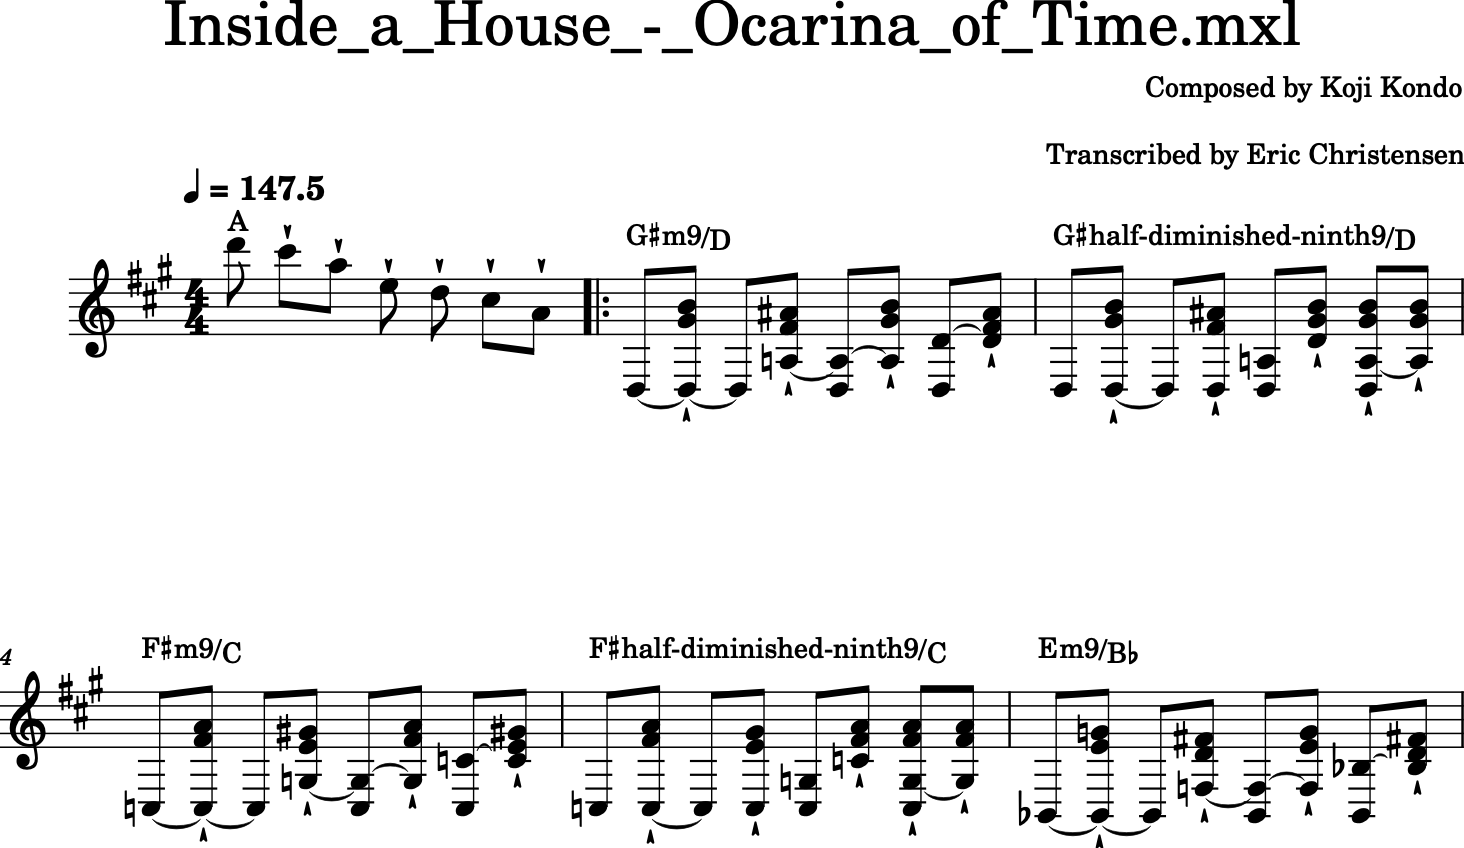

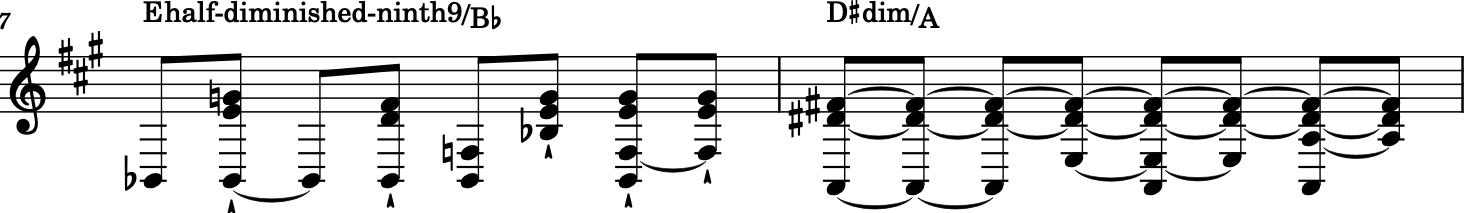

In [385]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Inside_a_House_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()

Scent of The Sea reveals an error with dealing with sus chords. In bar 19, we're playing a Gsus4 and on beat 3, the LH plays a 5th below the root, D. Because of that, when we assume the lowest note in the measure is the root, we get an error when trying to generate chord symbols. This is a very common bass pattern that should be dealt with.

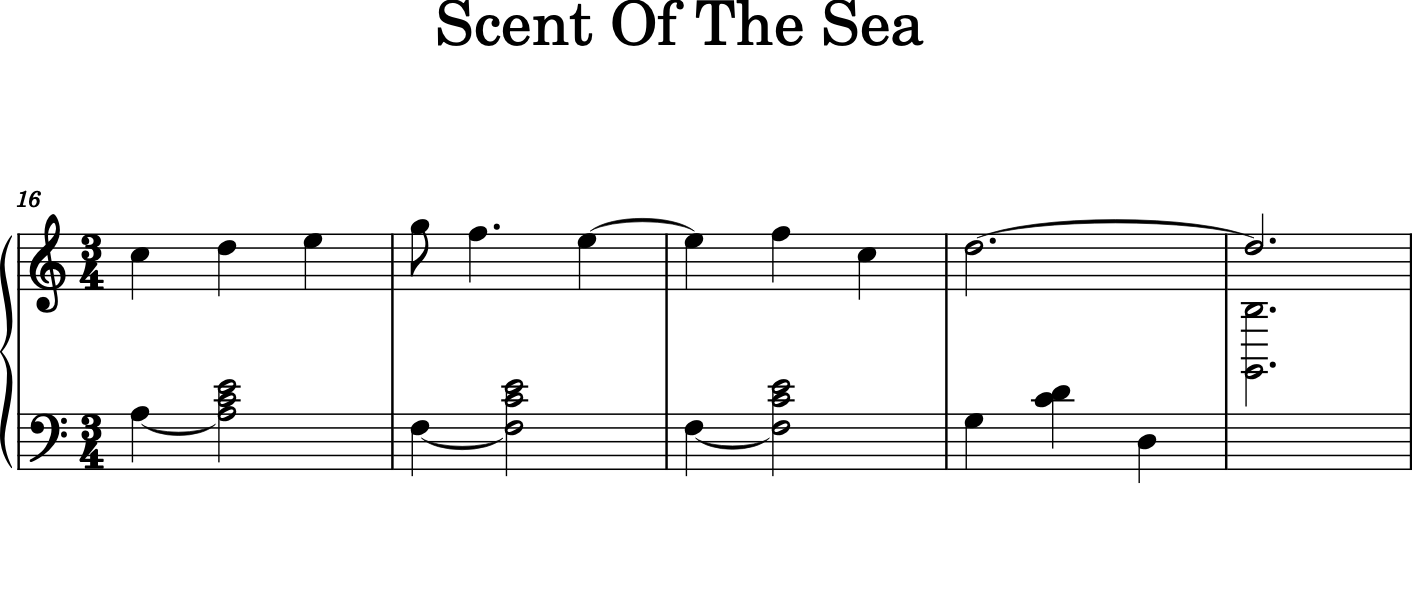

In [393]:
score.measures(16,20).show()

Skipping measure 19 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 34 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 35 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 39 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 40 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


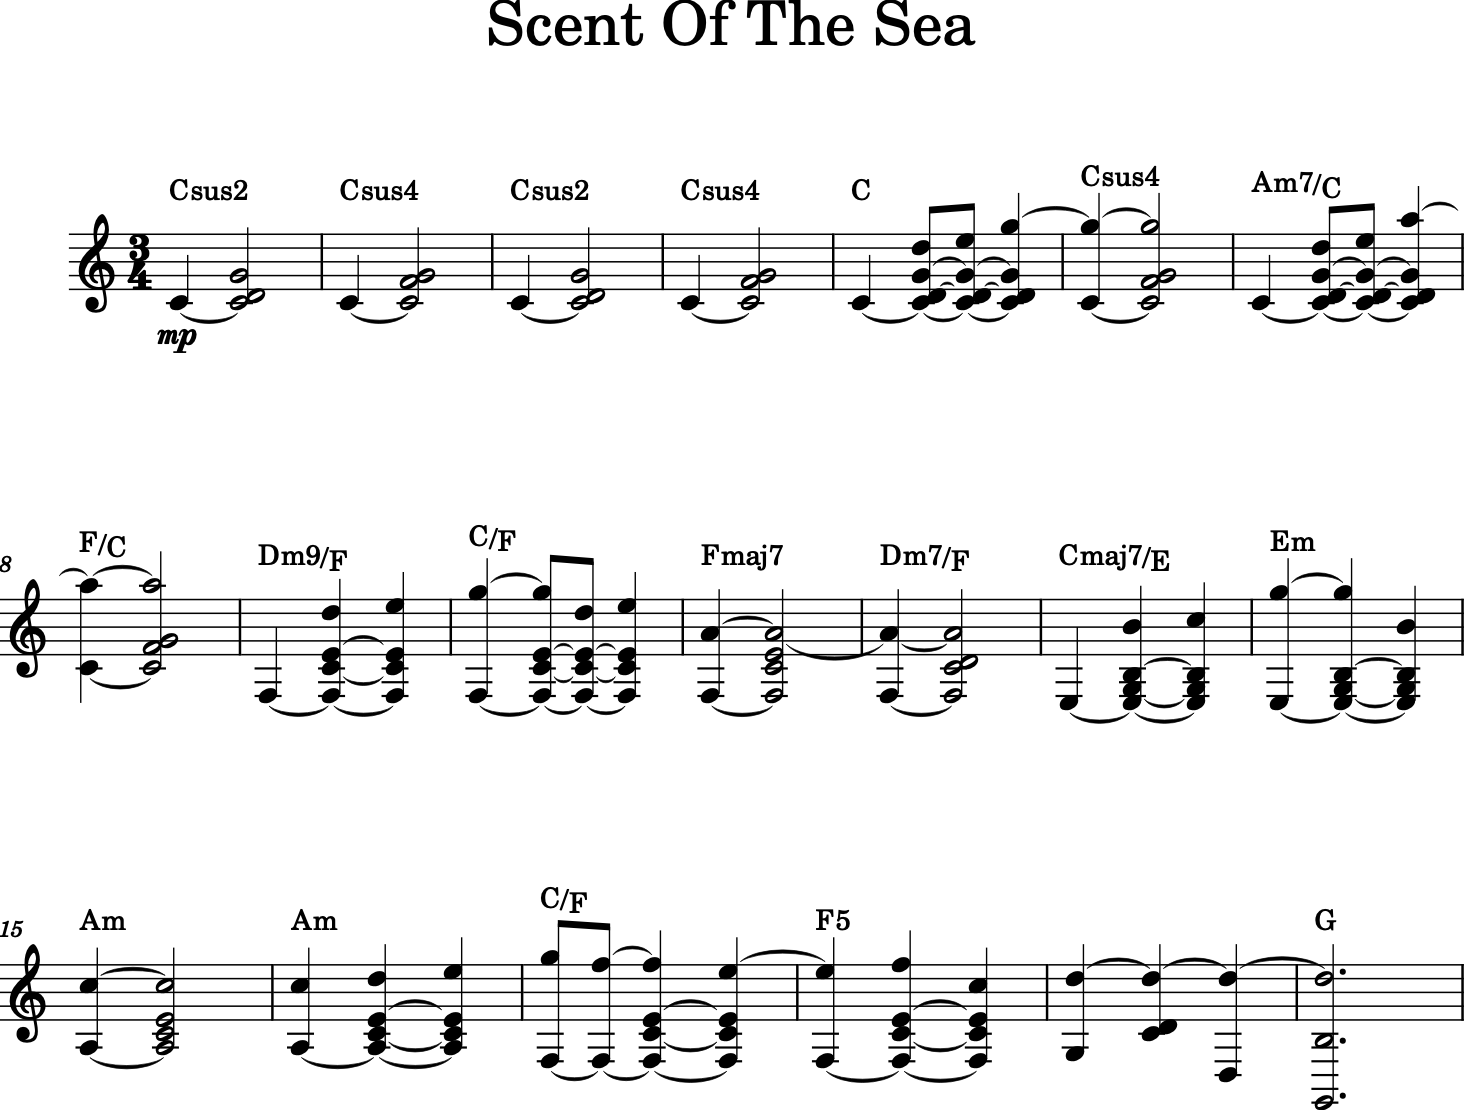

In [391]:
# Load the score from a MusicXML file
score = m21.converter.parse('./Setsuna_MXL/I Am Setsuna Piano Scores - 01_Piano - 03 Scent Of The Sea.musicxml')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,20)
select.show()

Let's change the error handling of the script. Instead of assuming the **lowest** note of the measure is the root note in error cases, let's have it assume that the **first** note on the downbeat of 1 is the root note.

In [433]:
def get_bass_note_on_downbeat(measure):
    """Return the lowest note or pitch occurring on the downbeat (beat 1) of a measure."""
    downbeat_elements = [element for element in measure.notes if element.offset == 0.0]
    if downbeat_elements:
        lowest_pitch = None
        
        # Find the lowest pitch, whether the element is a Note or Chord
        for element in downbeat_elements:
            if isinstance(element, m21.note.Note):
                if lowest_pitch is None or element.pitch < lowest_pitch:
                    lowest_pitch = element.pitch
            elif isinstance(element, m21.chord.Chord):
                # Get the lowest pitch in the chord
                chord_lowest_pitch = min(element.pitches, key=lambda p: p.midi)
                if lowest_pitch is None or chord_lowest_pitch < lowest_pitch:
                    lowest_pitch = chord_lowest_pitch
        
        return lowest_pitch
    return None

def filter_notes_below_bass_floor(notes_in_measure, bass_floor):
    """Filter out any notes that are lower than the bass note on the downbeat (bass_floor)."""
    filtered_notes = []
    
    for element in notes_in_measure:
        if element.offset == 0.0:  # Keep notes on the downbeat
            filtered_notes.append(element)
        elif isinstance(element, m21.note.Note):
            if bass_floor and element.pitch >= bass_floor:
                filtered_notes.append(element)  # Keep notes if they are higher than or equal to the downbeat bass note
        elif isinstance(element, m21.chord.Chord):
            # For chords, filter out pitches lower than the bass note on the downbeat
            pitches_above_bass = [p for p in element.pitches if bass_floor is None or p >= bass_floor]
            if pitches_above_bass:
                filtered_notes.append(m21.chord.Chord(pitches_above_bass))
    
    return filtered_notes
    

def generate_chord_symbols_from_chordify(score, threshold=0.25, cumulative_threshold=1.0):
    
    # Remove unpitched parts before chordification
    score = remove_unpitched_parts(score)
    
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()
    
    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all chords/notes in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)

        # Get the lowest note on the downbeat (beat 1)
        bass_note_on_downbeat = get_bass_note_on_downbeat(measure)
        
        # Filter out any notes below the bass floor
        filtered_notes = filter_notes_below_bass_floor(notes_in_measure, bass_note_on_downbeat)
        
        # Apply the filter to exclude passing tones
        filtered_notes = filter_weighted_duration(filtered_notes,threshold,cumulative_threshold)

        
        if filtered_notes:
            # Create a chord from all filtered notes in the measure
            combined_chord = m21.chord.Chord(filtered_notes)

            
            try:
                # Attempt to generate a chord symbol
                chord_symbol = m21.harmony.ChordSymbol()
                chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                
                # Ensure the chord symbol has a valid root
                if not chord_symbol.root():
                    raise ValueError("Invalid root note in chord symbol.")
                
                # Insert the ChordSymbol into the measure at the beginning
                measure.insert(0, chord_symbol)
                
            except Exception as e:
                #if returning an error, try setting the root to the lowest note of the chord
                try:
                    #set lowest note on beat 1 as root of the chord
                    combined_chord.root(bass_note_on_downbeat)

                    # Attempt to generate a chord symbol
                    chord_symbol = m21.harmony.ChordSymbol()
                    chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)
                    
                    # Ensure the chord symbol has a valid root
                    if not chord_symbol.root():
                        raise ValueError("Invalid root note in chord symbol.")
                    
                    # Insert the ChordSymbol into the measure at the beginning
                    measure.insert(0, chord_symbol)

                except Exception as e:
                    # Skip the measure if an error occurs
                    print(f"Skipping measure {measure.number} due to error: {e}")
    
    return chordified_score

Skipping measure 28 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 34 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 35 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 39 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>
Skipping measure 40 due to error: no pitches in chord <music21.harmony.ChordSymbol Chord Symbol Cannot Be Identified>


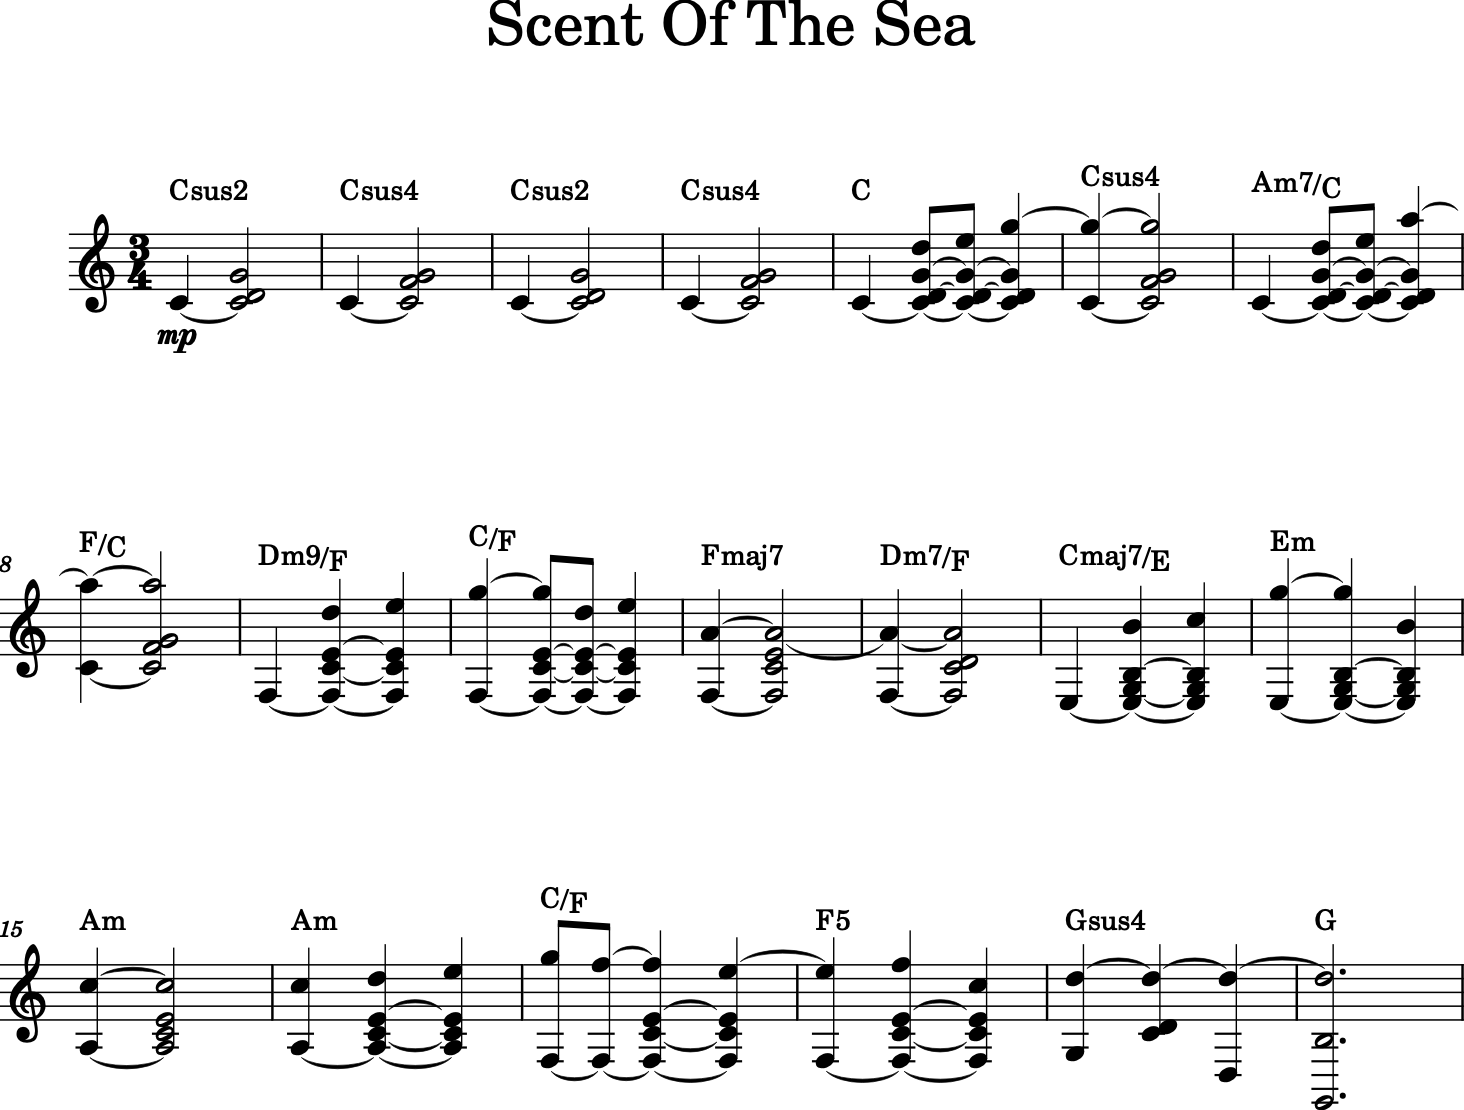

In [434]:
# Load the score from a MusicXML file
score = m21.converter.parse('./Setsuna_MXL/I Am Setsuna Piano Scores - 01_Piano - 03 Scent Of The Sea.musicxml')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,20)
select.show()

As far as the other errors go:
- m34 is really a continuation of m33 and doesn't need to be labeled
- m35 is A-B-C, and in context should be labeled as an `Am9`, but since 5 and 7 are both omitted, it trips up chord identification
- m39 would be Dm7 without the 5th, which again throws an error unless we add the `no 5th` chord type, and assume lowest note is the root in this case. The C note in this transcription may, however, be incorrect, because really the gesture going on in the accompaniment is more like `Dm/F C/E Bm/D`.
- m40 is really a continuation of m39 and doesn't need to be labeled

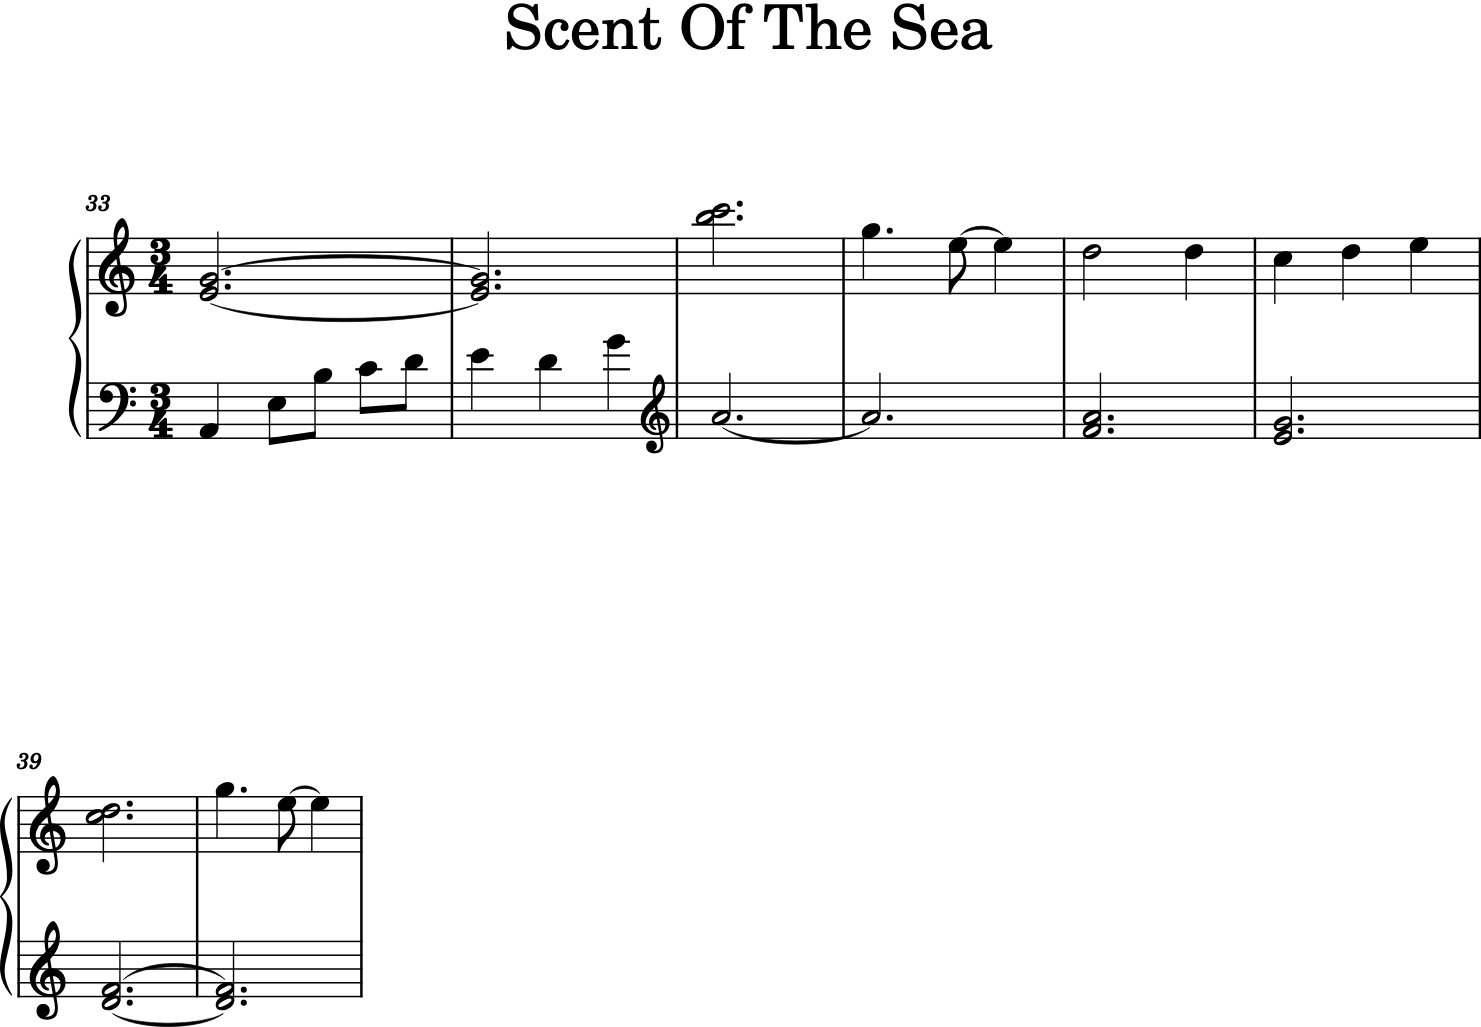

In [394]:
score.measures(33,40).show()

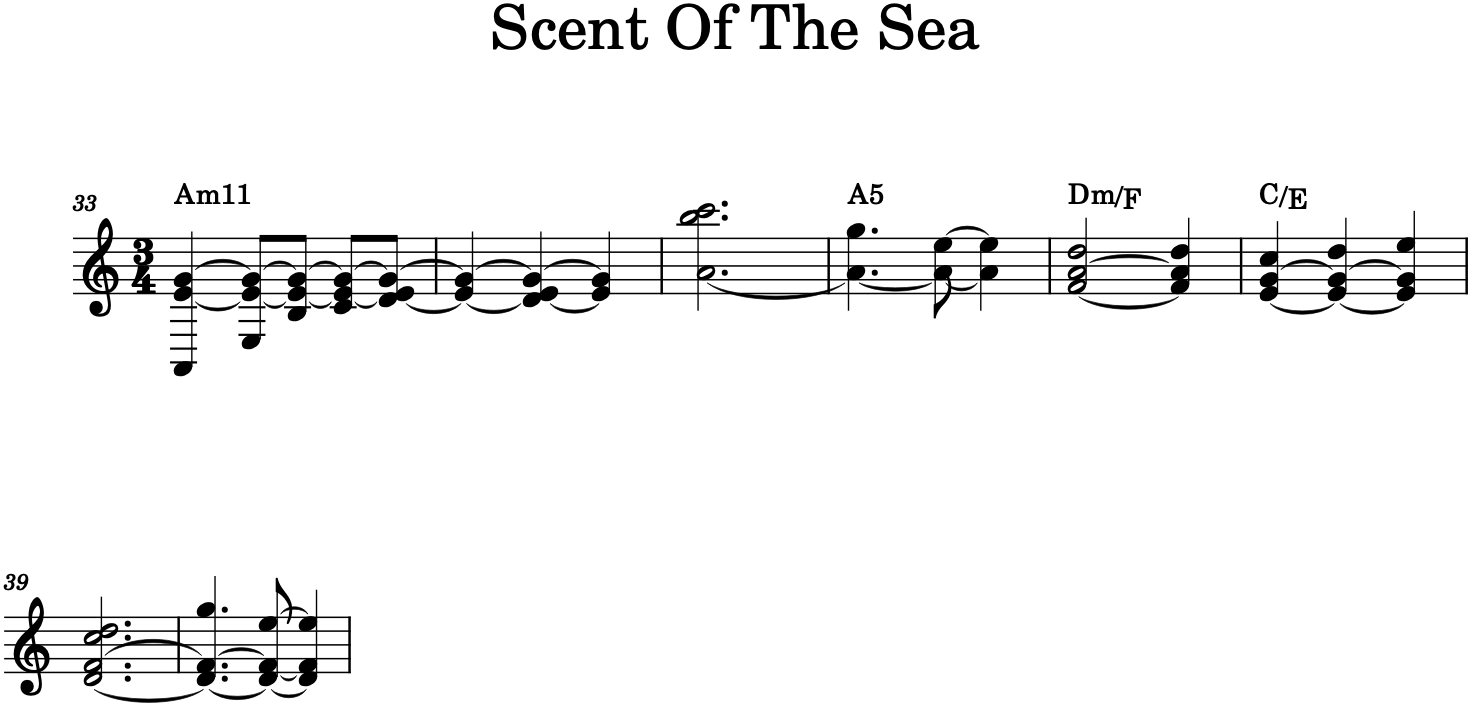

In [395]:
chordified_score.measures(33,40).show()

<h1>13th Chord? or Inversion?</h1>

Dm9/F and Fmaj13 are equivalent. Which one should we use? In cases like this, it may be best to surface both as options, and let a model or a human choose between the options based on what makes sense with the surrounding chords.

We can get the second option simply by setting the bass note as the root.

What may also be possible beyond having the user pick between the options is a Bayesian approach in which, given the key signature, surronding chords, and common chord progression fragments like `ii-V-I` and `IV-V-I`, we could generate a distribution of probabilities associated with each potential parsing of the chord. In my view, that is what a good analyst does when making a harmonic analysis.

<h1>Roman Numerals</h1>

It's simple to change our script to make Roman Numerals instead of chord symbols. A couple notes on that:
- Most examples I've seen thus far insert Roman Numeral symbols as lyrics so they appear at the bottom. I currently can't get Roman Numerals along the bottom and chord symbols along the top to display at the same time.
- Music21 has a lot of stuff for displaying figured bass figures, again classical tool, which you can chop off if you want
- I've so far had it assume we're analyzing from the major key associated with the key signature, not the relative minor. In theory, the most robust approach would involve analyzing from at least both the minor and major perspectives, and comparing the results to see which one is better. This is akin to model selection in data science.

In [438]:
def generate_roman_numerals(score,threshold=0.25, cumulative_threshold=1.0):
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()
    
    # Determine the key signature and assume major key
    key_signature = score.analyze('key')
    if key_signature.mode == 'minor':
        key_signature = key_signature.relative

    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        notes_in_measure = []
        
        # Collect all chords/notes in the measure
        for element in measure.notes:
            if isinstance(element, m21.note.Note) or isinstance(element, m21.chord.Chord):
                notes_in_measure.append(element)

        # Get the lowest note on the downbeat (beat 1)
        bass_note_on_downbeat = get_bass_note_on_downbeat(measure)
        
        # Filter out any notes below the bass floor
        filtered_notes = filter_notes_below_bass_floor(notes_in_measure, bass_note_on_downbeat)
        
        # Apply the filter to exclude passing tones
        filtered_notes = filter_weighted_duration(filtered_notes,threshold,cumulative_threshold)
        
        
        if filtered_notes:
            # Create a chord from all filtered notes in the measure
            combined_chord = m21.chord.Chord(filtered_notes)
            
            try:
                # Generate Roman numeral analysis based on the assumed key
                roman_numeral = m21.roman.romanNumeralFromChord(combined_chord, key_signature)
                
                # Add the Roman numeral as a lyric to the first note/chord of the measure
                if measure.notes:
                    first_element = measure.notes[0]
                    if isinstance(first_element, m21.note.Note):
                        first_element.addLyric(roman_numeral.romanNumeral)
                    elif isinstance(first_element, m21.chord.Chord):
                        first_element.addLyric(roman_numeral.romanNumeral)  # Add to the entire chord
                
            except Exception as e:
                # Skip the measure if an error occurs
                print(f"Skipping measure {measure.number} due to error: {e}")
    
    return chordified_score

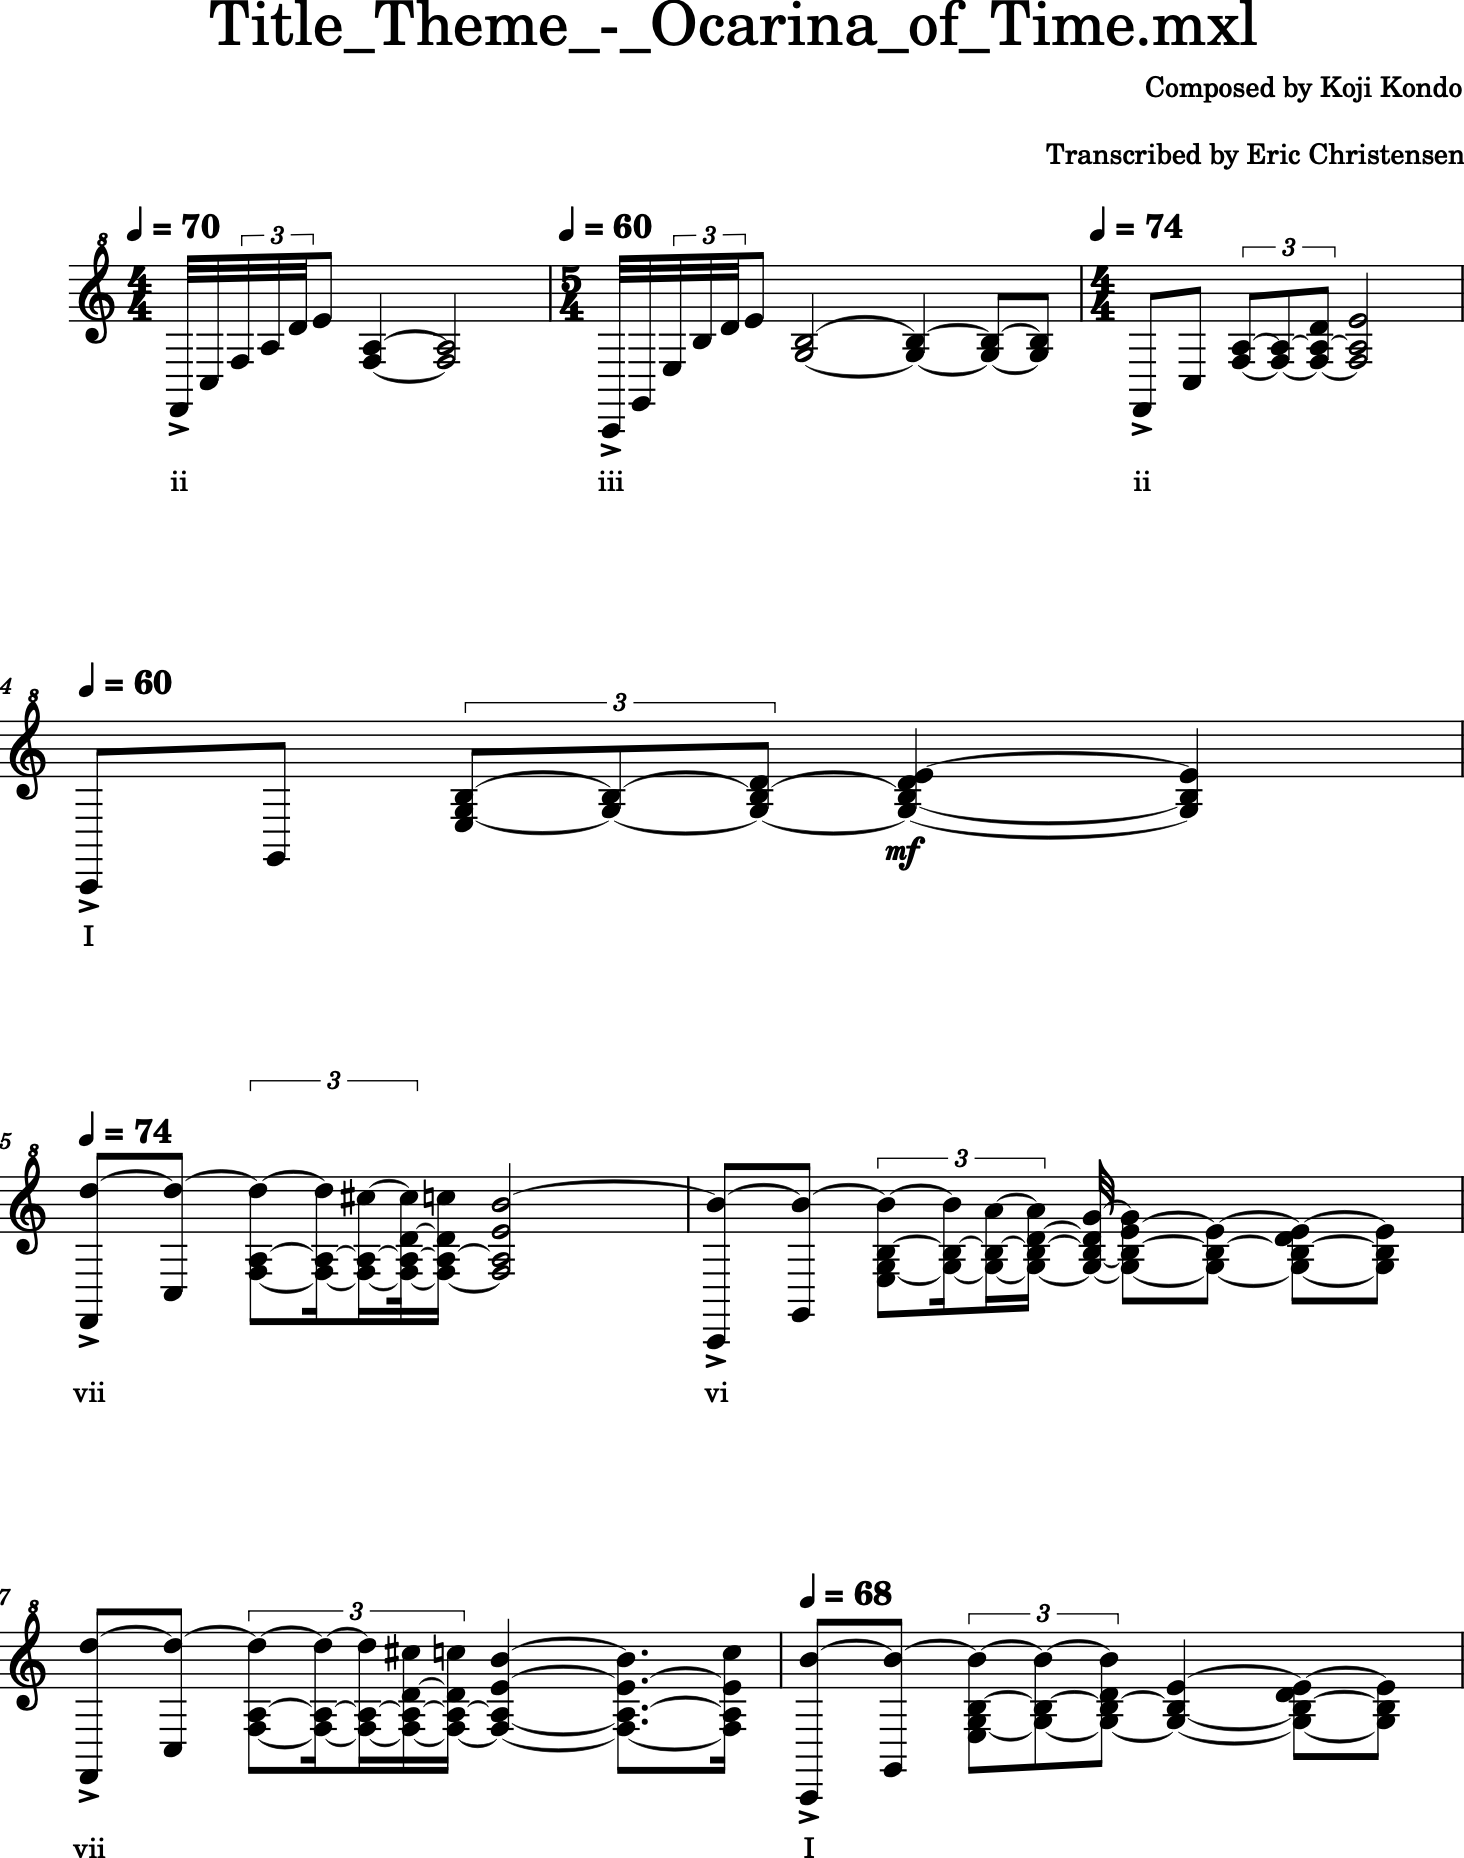

In [441]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Title_Theme_-_Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_roman_numerals(score)
    
# Append the chordify staff to the original score
combined_score = m21.stream.Score()
for part in score.parts:
    combined_score.append(part)
combined_score.append(chordified_score) 

# Force a layout update to ensure lyrics are displayed
chordified_score.makeMeasures(inPlace=True)

chordified_score.measures(1,8).show()

The B Section of the Title Theme  has 2 chords at the end borrowed from C minor. The Roman Numeral analysis caught that (leaving me impressed), although because of the `13th Chord? Or Inversion?` exception, instead of `F G F G F G {Ab} {Bbadd6}` or `IV V IV V IV V {bVI} {bVII}`, it parsed the chords as `F G F G F G {Ab} {Gm/Bb}` or `IV V IV V IV V {bVI} {v6}`.

Again, that's not wrong, per se, but `{bVI} {bVII} I` is a chord progression fragment talked about in this space as the Mario Cadence. 

Being able to specify different traditions you're coming from in the analysis, or chord fragments to look out for like this would help the script to disambiguate.

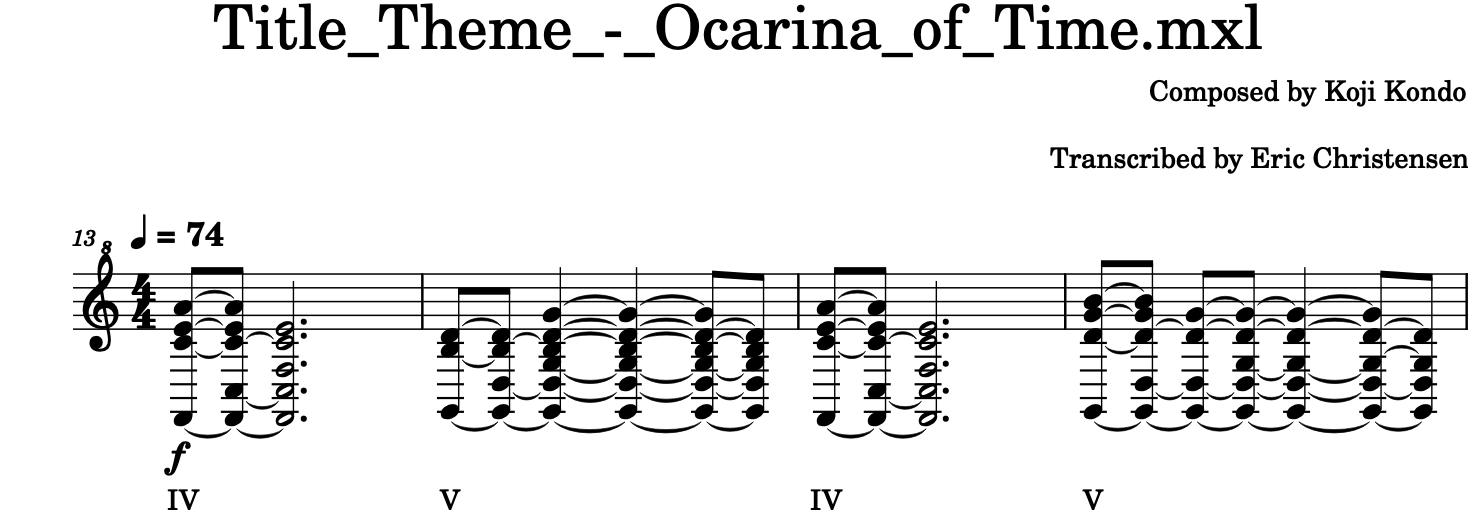

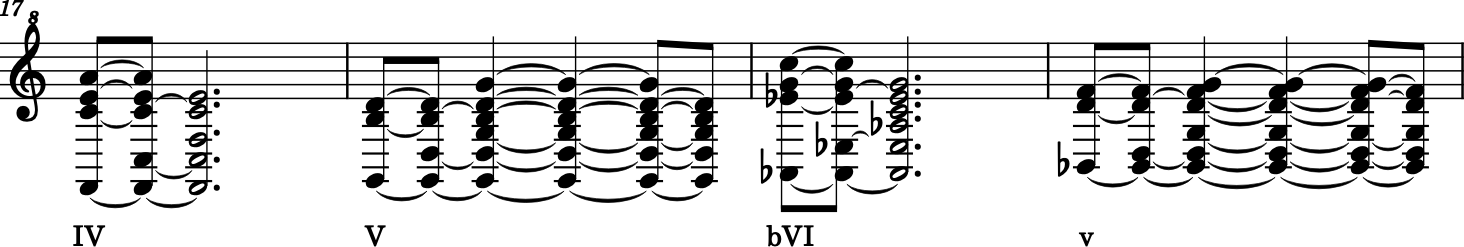

In [442]:
chordified_score.measures(13,20).show()

<h2>Model Selection</h2>

Here are some additional thoughts on how one might implement model selection between various relative mode options. Like regression regularization in data science, we want to penalize a model for unwarranted complexity.

If we had a score for each chord that shows how diatonic it is to the candidate key (for example, deduct for every non-diatonic note), we could sum that metric across all chords and pick the candidate key that maximizes the summed diatonicity of all of the chords.

This could be useful for evaluating a measure or section with lots of accidentals that might suggest a new temporary key that doesn't have a change of key signature, which is certainly commonplace.

However, if we are evaluting between C major and A minor, we don't get a different number of out of key notes because they are modes of the same scale.

We need something that gives a higher score for simple chords like `I IV V I` and a lower score for exotic ones with inversions `viio65 ii6 bII6` (no relation to the previous set of chords.

`music21` does have `RomanNumeral.functionalityScore()` explained in the [docs](https://www.music21.org/music21docs/moduleReference/moduleRoman.html#music21.roman.RomanNumeral.functionalityScore), which does try to acheive this. Inspection of the Roman Numeral [class](https://github.com/cuthbertLab/music21/blob/master/music21/roman.py) shows that this is implemented as a hard encoded dictionary.

```
functionalityScores: dict[str, int] = {
    'I': 100,
    'i': 90,
    'V7': 80,
    'V': 70,
    'V65': 68,
    'I6': 65,
    'V6': 63,
    'V43': 61,
    'I64': 60,
    'IV': 59,
    'i6': 58,
    'viio7': 57,
    'V42': 55,
    'viio65': 53,
    'viio6': 52,
    '#viio65': 51,
    'ii': 50,
    '#viio6': 49,
    'ii65': 48,
    'ii43': 47,
    'ii42': 46,
    'IV6': 45,
    'ii6': 43,
    'VI': 42,
    '#VI': 41,
    'vi': 40,
    'viio': 39,
    '#viio': 38,
    'iio': 37,  # common in Minor
    'iio42': 36,
    'bII6': 35,  # Neapolitan
    'It6': 34,
    'Ger65': 33,
    'iio43': 32,
    'iio65': 31,
    'Fr43': 30,
    '#vio': 28,
    '#vio6': 27,
    'III': 22,
    'Sw43': 21,
    'v': 20,
    'VII': 19,
    'VII7': 18,
    'IV65': 17,
    'IV7': 16,
    'iii': 15,
    'iii6': 12,
    'vi6': 10,
}
```

<h1>Changing the Harmonic Rhythm</h1>

Kokiri Forest has two chords per measure, which currently messes the script up.

Skipping measure 2 due to error: majaddc is not a supported accidental type
Skipping measure 4 due to error: addd is not a supported accidental type
Skipping measure 5 due to error: addd is not a supported accidental type
Skipping measure 6 due to error: addd is not a supported accidental type
Skipping measure 10 due to error: addd is not a supported accidental type
Skipping measure 12 due to error: addd is not a supported accidental type
Skipping measure 13 due to error: addd is not a supported accidental type
Skipping measure 15 due to error: maddd is not a supported accidental type
Skipping measure 19 due to error: maddd is not a supported accidental type
Skipping measure 22 due to error: addd is not a supported accidental type
Skipping measure 23 due to error: addd is not a supported accidental type
Skipping measure 25 due to error: addd is not a supported accidental type
Skipping measure 32 due to error: addd is not a supported accidental type


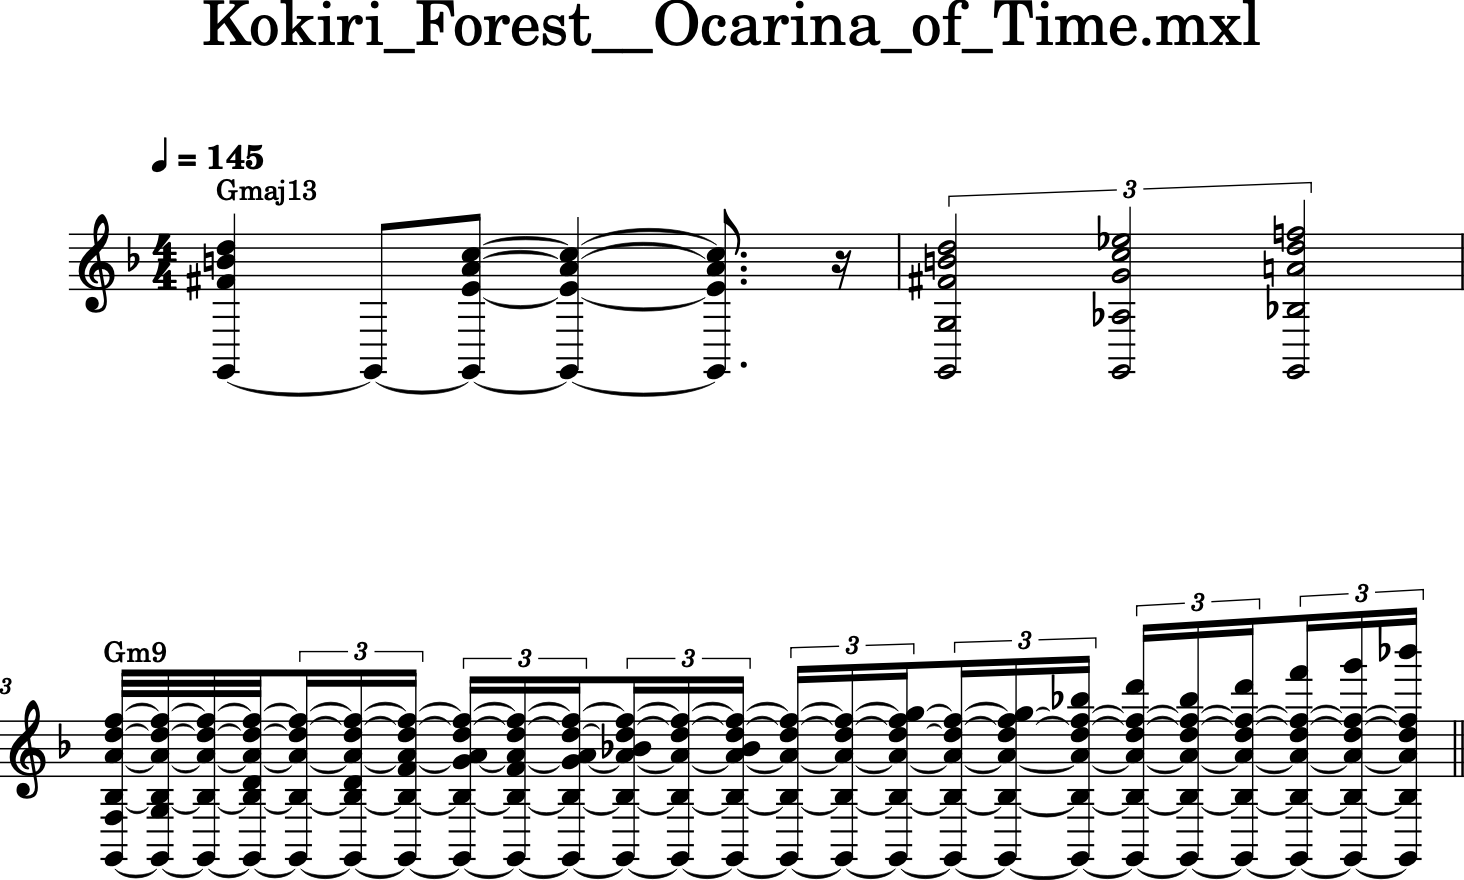

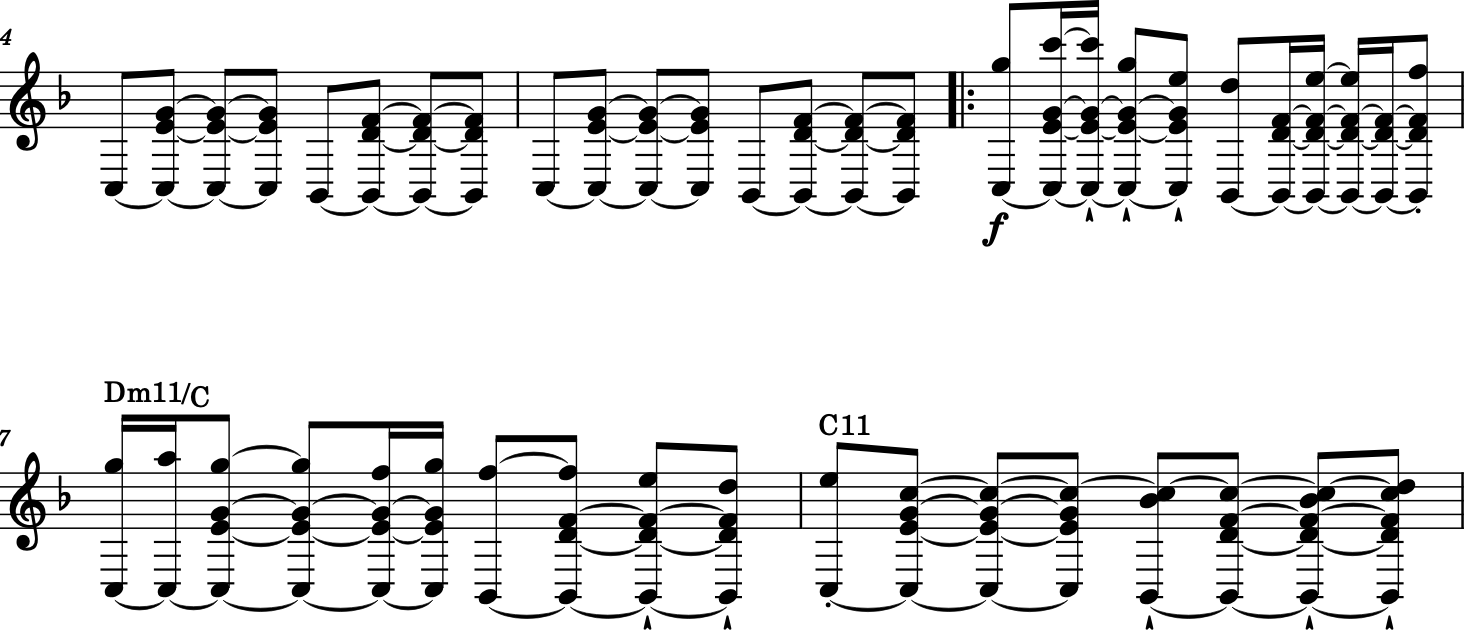

In [443]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Kokiri_Forest__Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify(score)
    

select = chordified_score.measures(1,8)
select.show()

Let's add a toggle to the script to let us calculate chords every 2 beats, like in this song, instead of every measure. Unfortunately, this adds quite a bit of complexity. The current draft of this script doesn't filter for the `1-5(8vb)` bass pattern like we did above, but if we wanted to add that, we'd add logic to assume the first bass note of each **segment** is the intended bass note for the chord. 

In [450]:
def generate_chord_symbols_from_chordify_beats(score, threshold=0.25, cumulative_threshold=1.0, beats_per_segment=4):
    # Remove unpitched parts before chordification
    score = remove_unpitched_parts(score)
    
    # Chordify the entire score to create a harmonic reduction
    chordified_score = score.chordify()

    # Iterate through each measure in the chordified score
    for measure in chordified_score.getElementsByClass(m21.stream.Measure):
        measure_duration = measure.duration.quarterLength
        num_segments = int(measure_duration / beats_per_segment)

        for i in range(num_segments):
            start_offset = i * beats_per_segment
            end_offset = start_offset + beats_per_segment
            notes_in_segment = []

            # Collect notes/chords within the segment
            for element in measure.notes:
                if start_offset <= element.offset < end_offset:
                    notes_in_segment.append(element)

            # Apply the filter to exclude passing tones
            filtered_notes = filter_weighted_duration(notes_in_segment, threshold, cumulative_threshold)
            
            if filtered_notes:
                try:
                    # Create a chord from all filtered notes in the segment
                    combined_chord = m21.chord.Chord(filtered_notes)
                    
                    # Ensure the chord symbol has a valid root
                    if not combined_chord.pitches:
                        continue  # Skip empty chords
                    
                    # Attempt to generate a chord symbol
                    chord_symbol = m21.harmony.ChordSymbol()
                    chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)

                    # Insert the ChordSymbol into the measure at the appropriate offset
                    measure.insert(start_offset, chord_symbol)
                    
                except Exception as e:
                    # If returning an error, try setting the root to the lowest note of the chord
                    try:
                        # Set bass note as root of the chord
                        combined_chord.root(combined_chord.bass())

                        # Attempt to generate a chord symbol
                        chord_symbol = m21.harmony.ChordSymbol()
                        chord_symbol.figure = m21.harmony.chordSymbolFigureFromChord(combined_chord)

                        # Ensure the chord symbol has a valid root
                        if not combined_chord.root():
                            raise ValueError("Invalid root note in chord symbol.")
                        
                        # Insert the ChordSymbol into the measure at the appropriate offset
                        measure.insert(start_offset, chord_symbol)

                    except Exception as e:
                        # Skip the measure if an error occurs
                        print(f"Skipping segment in measure {measure.number} due to error: {e}")
    
    return chordified_score

This works! Also we're benefiting from our passing tones logic I added earlier because it's filtering out all of the flourishes in the melody.

Skipping segment in measure 2 due to error: majaddc is not a supported accidental type
Skipping segment in measure 10 due to error: -+adde is not a supported accidental type
Skipping segment in measure 25 due to error: addf# is not a supported accidental type
Skipping segment in measure 25 due to error: -adde is not a supported accidental type
Skipping segment in measure 27 due to error: -maddg is not a supported accidental type


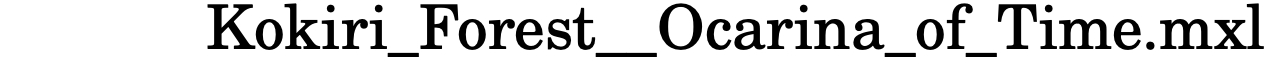

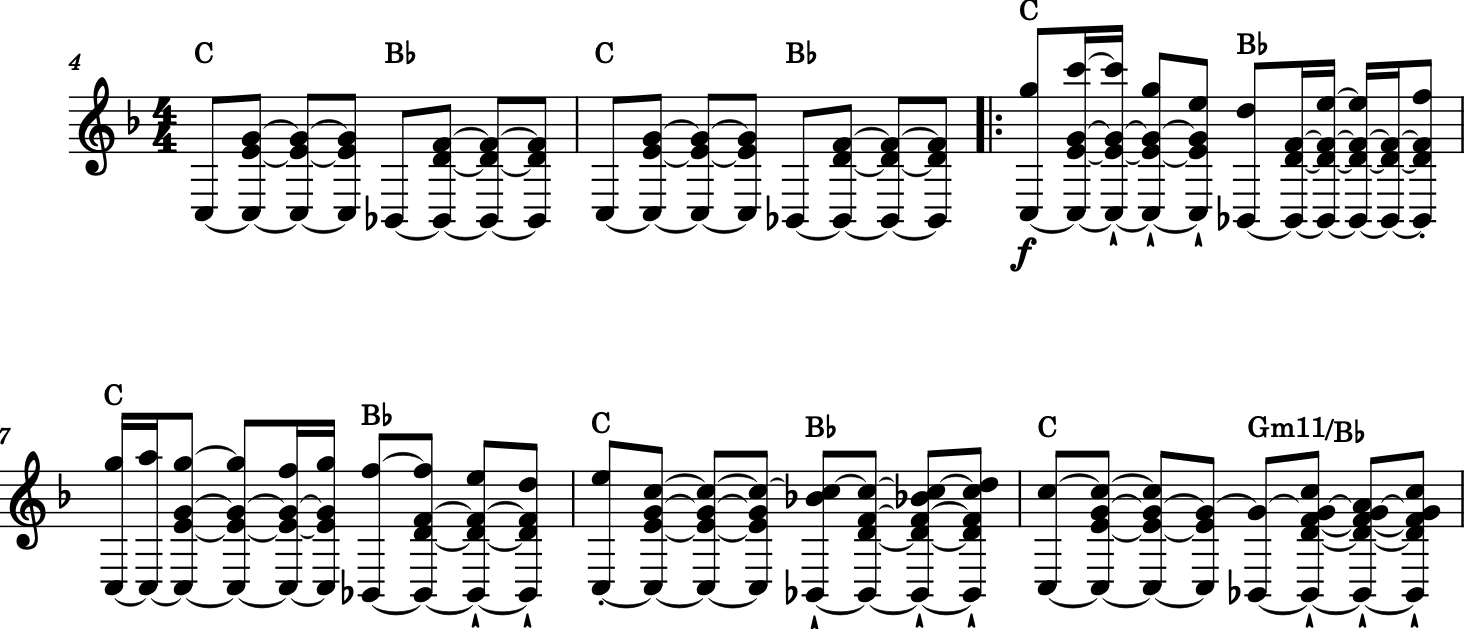

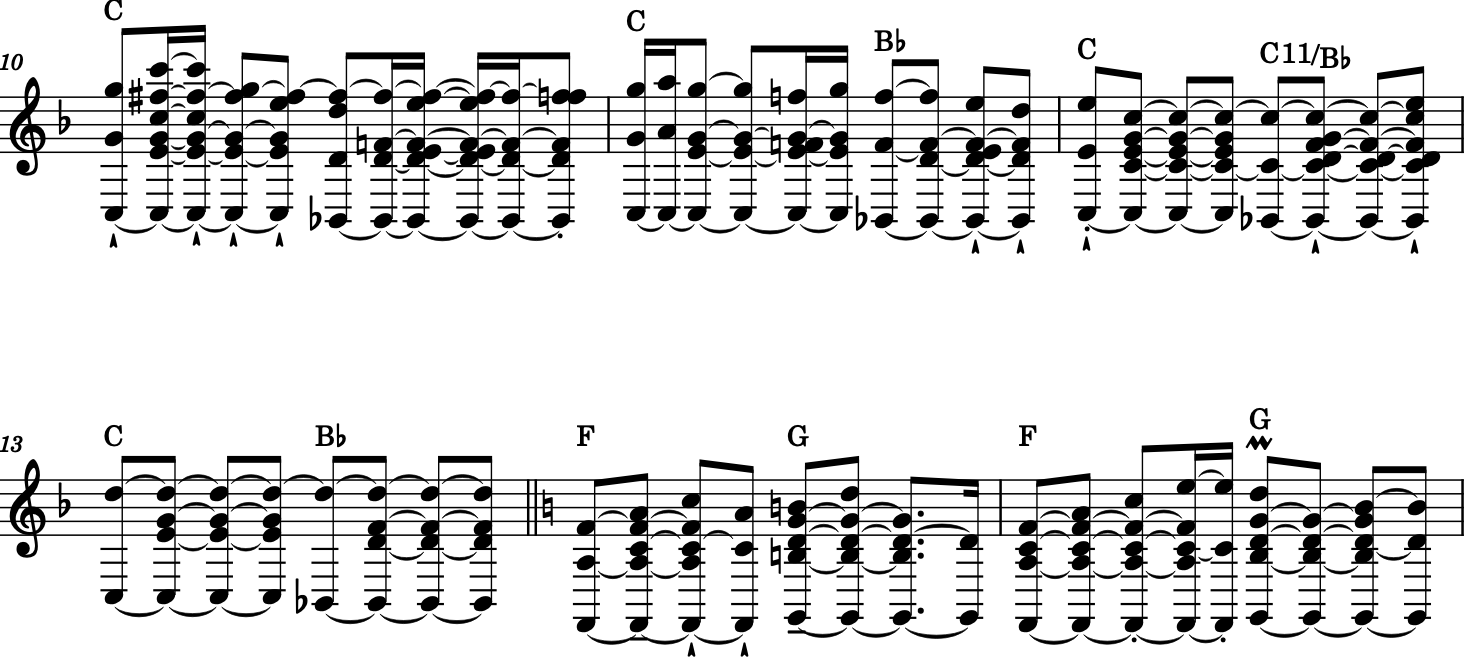

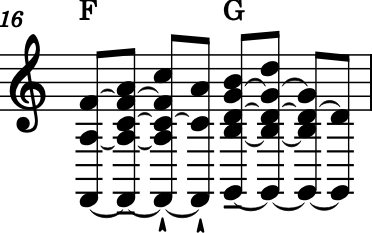

In [451]:
# Load the score from a MusicXML file
score = m21.converter.parse('./OOT_MXML/Kokiri_Forest__Ocarina_of_Time.mxl')
    
# Generate the chordify staff with chord symbols
chordified_score = generate_chord_symbols_from_chordify_beats(score,beats_per_segment=2)
    

select = chordified_score.measures(4,16)
select.show()

For example, the piccolo flourishes in measure 7 would add A and F to what is otherwise a C chord, but a symbol like `C(add4,add6)` would be overly complex for what is really a harmonically simple measure.

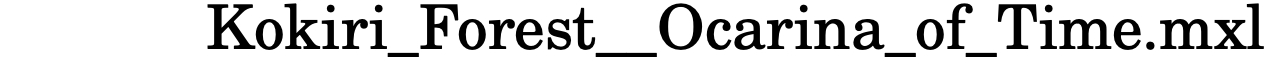

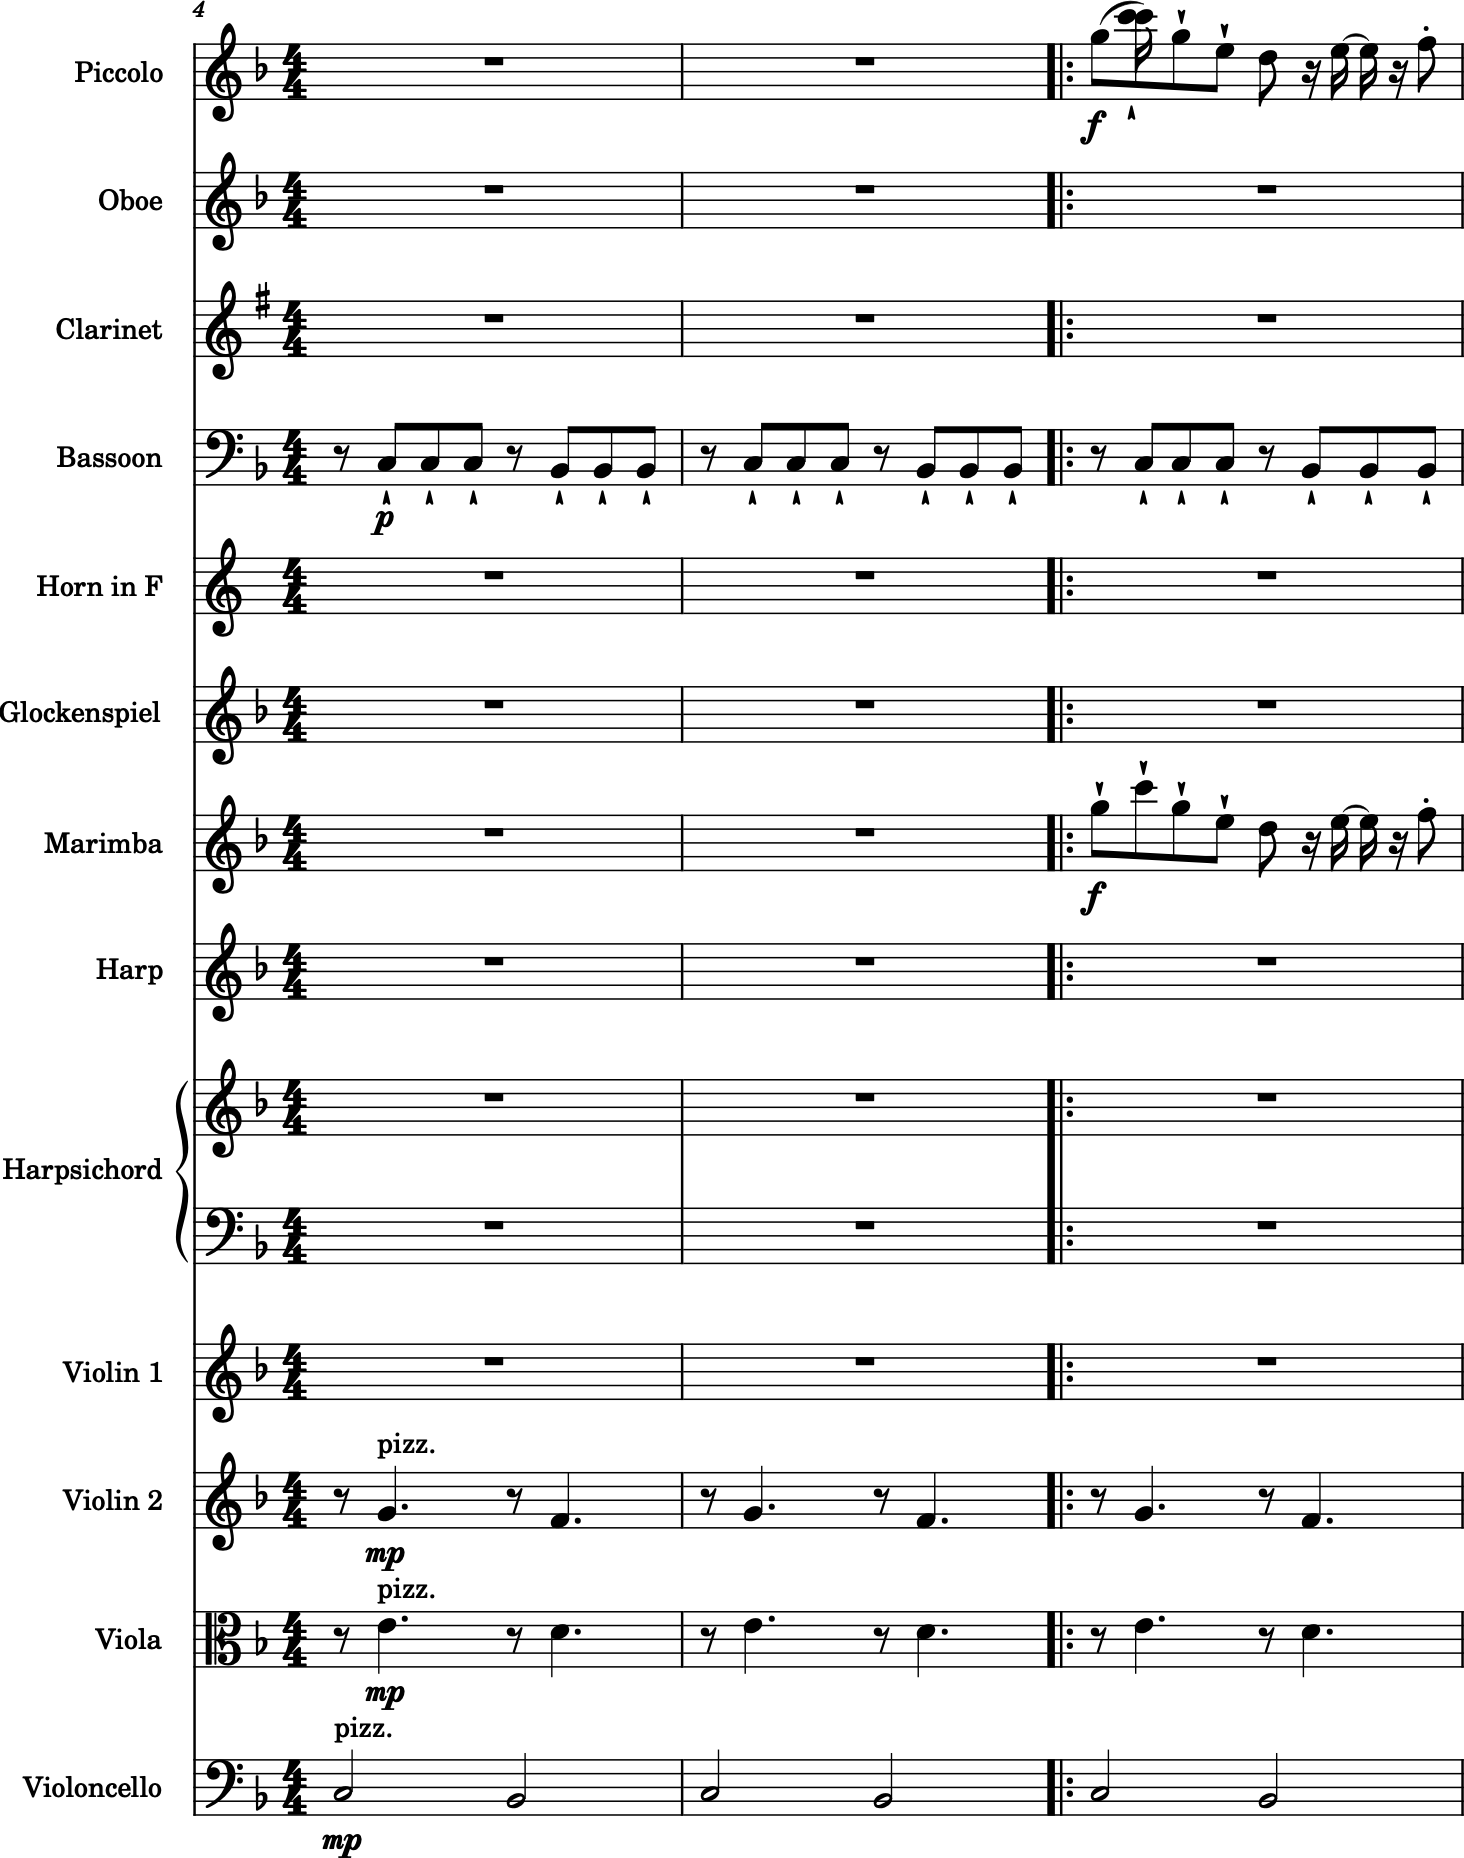

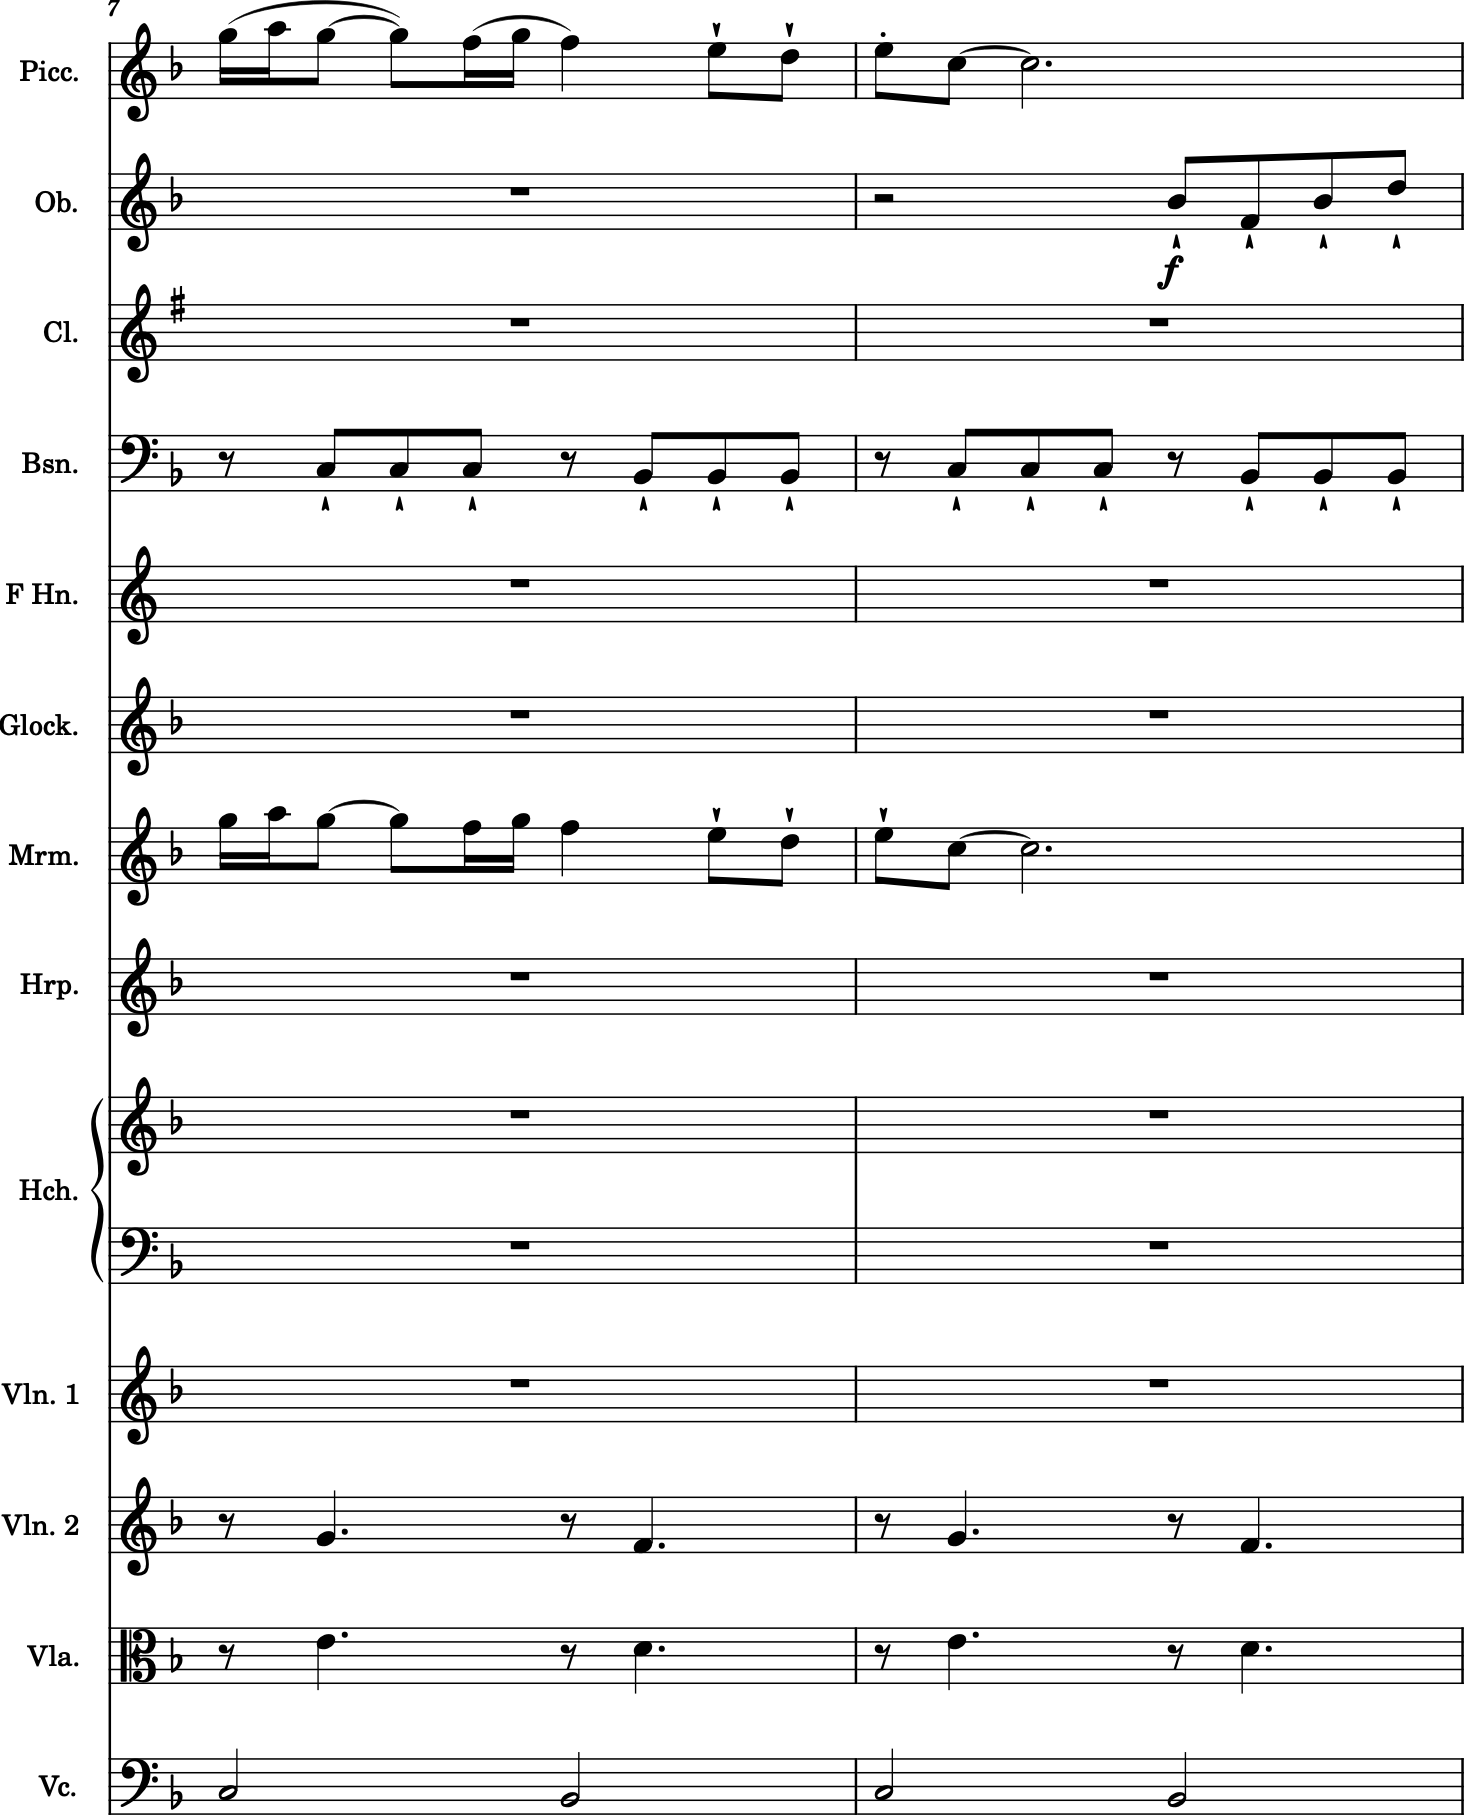

In [412]:
score.measures(4,8).show()

I hope you've enjoyed diving into the weeds of automated chord naming with me!